In [1]:
# example of lsgan for mnist
import tensorflow as tf
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dense(1, activation='linear', kernel_initializer=init))
	# compile model with L2 loss
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 256 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(Reshape((7, 7, 256)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# upsample to 28x28
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), padding='same', kernel_initializer=init))
	model.add(Activation('tanh'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	for layer in discriminator.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model with L2 loss
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

# load mnist images
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# # select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('Saved %s and %s' % (filename1, filename2))

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	pyplot.plot(d1_hist, label='dloss1')
	pyplot.plot(d2_hist, label='dloss2')
	pyplot.plot(g_hist, label='gloss')
	pyplot.legend()
	filename = 'plot_line_plot_loss.png'
	pyplot.savefig(filename)
	pyplot.close()
	print('Saved %s' % (filename))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=64):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for storing loss, for plotting later
	d1_hist, d2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# prepare real and fake samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update the generator via the discriminator's error
		z_input = generate_latent_points(latent_dim, n_batch)
		y_real2 = ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(z_input, y_real2)
		# summarize loss on this batch
		print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))
		# record history
		d1_hist.append(d_loss1)
		d2_hist.append(d_loss2)
		g_hist.append(g_loss)
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, latent_dim)
	# create line plot of training history
	plot_history(d1_hist, d2_hist, g_hist)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

(60000, 28, 28, 1)
>1, d1=1.377, d2=0.249 g=1.170
>2, d1=2.698, d2=0.378 g=1.067
>3, d1=1.080, d2=0.622 g=0.823
>4, d1=0.410, d2=0.299 g=0.747
>5, d1=0.303, d2=0.194 g=0.987
>6, d1=0.306, d2=0.135 g=0.616
>7, d1=0.340, d2=0.203 g=0.461
>8, d1=0.668, d2=0.172 g=0.499
>9, d1=0.711, d2=0.226 g=0.536
>10, d1=0.388, d2=0.314 g=0.462
>11, d1=0.366, d2=0.342 g=0.465
>12, d1=0.239, d2=0.227 g=0.325
>13, d1=0.227, d2=0.157 g=0.320
>14, d1=0.275, d2=0.183 g=0.592
>15, d1=1.087, d2=0.246 g=0.309
>16, d1=2.130, d2=0.589 g=0.629
>17, d1=1.318, d2=0.861 g=0.376
>18, d1=0.380, d2=0.793 g=0.317
>19, d1=0.359, d2=0.286 g=0.487
>20, d1=0.466, d2=0.159 g=0.220
>21, d1=0.277, d2=0.090 g=0.269
>22, d1=0.306, d2=0.115 g=0.224
>23, d1=0.373, d2=0.128 g=0.299
>24, d1=0.327, d2=0.127 g=0.252
>25, d1=0.146, d2=0.264 g=0.324
>26, d1=0.149, d2=0.337 g=0.732
>27, d1=0.249, d2=0.526 g=1.263
>28, d1=0.191, d2=1.215 g=2.350
>29, d1=0.302, d2=2.026 g=2.631
>30, d1=0.523, d2=1.443 g=0.382
>31, d1=0.631, d2=1.345 g=0.90

>252, d1=0.055, d2=0.031 g=0.320
>253, d1=0.045, d2=0.026 g=0.177
>254, d1=0.038, d2=0.027 g=0.165
>255, d1=0.041, d2=0.013 g=0.183
>256, d1=0.041, d2=0.011 g=0.149
>257, d1=0.044, d2=0.017 g=0.134
>258, d1=0.027, d2=0.012 g=0.135
>259, d1=0.037, d2=0.012 g=0.206
>260, d1=0.047, d2=0.019 g=0.126
>261, d1=0.087, d2=0.035 g=0.206
>262, d1=0.045, d2=0.018 g=0.160
>263, d1=0.046, d2=0.017 g=0.158
>264, d1=0.030, d2=0.008 g=0.172
>265, d1=0.013, d2=0.009 g=0.154
>266, d1=0.027, d2=0.007 g=0.157
>267, d1=0.034, d2=0.014 g=0.247
>268, d1=0.026, d2=0.017 g=0.130
>269, d1=0.043, d2=0.062 g=0.395
>270, d1=0.033, d2=0.130 g=0.047
>271, d1=0.048, d2=0.411 g=0.886
>272, d1=0.095, d2=0.807 g=0.077
>273, d1=0.106, d2=1.580 g=1.519
>274, d1=0.114, d2=2.282 g=0.075
>275, d1=0.085, d2=2.803 g=1.309
>276, d1=0.129, d2=2.169 g=0.151
>277, d1=0.064, d2=1.138 g=0.388
>278, d1=0.048, d2=0.302 g=0.343
>279, d1=0.047, d2=0.152 g=0.419
>280, d1=0.056, d2=0.053 g=0.345
>281, d1=0.027, d2=0.052 g=0.382
>282, d1=0

>501, d1=0.069, d2=0.111 g=0.750
>502, d1=0.055, d2=0.081 g=0.872
>503, d1=0.094, d2=0.133 g=0.719
>504, d1=0.112, d2=0.089 g=0.694
>505, d1=0.146, d2=0.085 g=0.685
>506, d1=0.145, d2=0.064 g=0.764
>507, d1=0.118, d2=0.043 g=0.761
>508, d1=0.050, d2=0.035 g=0.552
>509, d1=0.029, d2=0.102 g=0.758
>510, d1=0.112, d2=0.046 g=0.728
>511, d1=0.208, d2=0.075 g=0.731
>512, d1=0.081, d2=0.038 g=0.867
>513, d1=0.139, d2=0.045 g=0.744
>514, d1=0.053, d2=0.050 g=0.738
>515, d1=0.073, d2=0.078 g=0.833
>516, d1=0.086, d2=0.061 g=0.735
>517, d1=0.072, d2=0.071 g=0.717
>518, d1=0.095, d2=0.084 g=0.959
>519, d1=0.073, d2=0.042 g=0.617
>520, d1=0.044, d2=0.048 g=0.501
>521, d1=0.083, d2=0.087 g=0.640
>522, d1=0.050, d2=0.064 g=0.716
>523, d1=0.077, d2=0.053 g=0.720
>524, d1=0.081, d2=0.045 g=0.607
>525, d1=0.097, d2=0.067 g=0.777
>526, d1=0.114, d2=0.053 g=0.620
>527, d1=0.120, d2=0.037 g=0.475
>528, d1=0.062, d2=0.037 g=0.560
>529, d1=0.021, d2=0.028 g=0.568
>530, d1=0.048, d2=0.037 g=0.431
>531, d1=0

>750, d1=0.024, d2=0.076 g=0.285
>751, d1=0.093, d2=0.021 g=0.128
>752, d1=0.017, d2=0.024 g=0.102
>753, d1=0.020, d2=0.034 g=0.100
>754, d1=0.037, d2=0.075 g=0.166
>755, d1=0.060, d2=0.020 g=0.112
>756, d1=0.041, d2=0.027 g=0.185
>757, d1=0.026, d2=0.036 g=0.179
>758, d1=0.023, d2=0.031 g=0.172
>759, d1=0.031, d2=0.022 g=0.094
>760, d1=0.034, d2=0.091 g=0.040
>761, d1=0.057, d2=0.096 g=0.088
>762, d1=0.034, d2=0.042 g=0.204
>763, d1=0.078, d2=0.027 g=0.093
>764, d1=0.019, d2=0.037 g=0.042
>765, d1=0.023, d2=0.076 g=0.065
>766, d1=0.021, d2=0.041 g=0.114
>767, d1=0.028, d2=0.030 g=0.091
>768, d1=0.020, d2=0.038 g=0.131
>769, d1=0.058, d2=0.041 g=0.054
>770, d1=0.025, d2=0.113 g=0.185
>771, d1=0.048, d2=0.076 g=0.306
>772, d1=0.076, d2=0.041 g=0.216
>773, d1=0.055, d2=0.079 g=0.263
>774, d1=0.026, d2=0.023 g=0.307
>775, d1=0.059, d2=0.041 g=0.166
>776, d1=0.049, d2=0.058 g=0.115
>777, d1=0.064, d2=0.030 g=0.235
>778, d1=0.027, d2=0.043 g=0.347
>779, d1=0.069, d2=0.039 g=0.174
>780, d1=0

>997, d1=0.051, d2=0.025 g=0.027
>998, d1=0.040, d2=0.024 g=0.038
>999, d1=0.039, d2=0.057 g=0.155
>1000, d1=0.084, d2=0.018 g=0.043
>1001, d1=0.028, d2=0.034 g=0.034
>1002, d1=0.037, d2=0.120 g=0.026
>1003, d1=0.055, d2=0.104 g=0.096
>1004, d1=0.074, d2=0.036 g=0.018
>1005, d1=0.025, d2=0.246 g=0.095
>1006, d1=0.090, d2=0.036 g=0.060
>1007, d1=0.053, d2=0.037 g=0.021
>1008, d1=0.064, d2=0.015 g=0.046
>1009, d1=0.036, d2=0.027 g=0.016
>1010, d1=0.033, d2=0.017 g=0.048
>1011, d1=0.069, d2=0.026 g=0.019
>1012, d1=0.029, d2=0.022 g=0.018
>1013, d1=0.045, d2=0.048 g=0.035
>1014, d1=0.063, d2=0.028 g=0.042
>1015, d1=0.016, d2=0.021 g=0.016
>1016, d1=0.030, d2=0.043 g=0.038
>1017, d1=0.060, d2=0.056 g=0.031
>1018, d1=0.024, d2=0.115 g=0.098
>1019, d1=0.097, d2=0.025 g=0.032
>1020, d1=0.024, d2=0.034 g=0.075
>1021, d1=0.026, d2=0.025 g=0.042
>1022, d1=0.028, d2=0.026 g=0.034
>1023, d1=0.024, d2=0.016 g=0.029
>1024, d1=0.025, d2=0.043 g=0.018
>1025, d1=0.063, d2=0.032 g=0.095
>1026, d1=0.105, 

>1239, d1=0.063, d2=0.055 g=0.184
>1240, d1=0.051, d2=0.016 g=0.103
>1241, d1=0.023, d2=0.066 g=0.107
>1242, d1=0.039, d2=0.031 g=0.026
>1243, d1=0.069, d2=0.020 g=0.218
>1244, d1=0.096, d2=0.033 g=0.020
>1245, d1=0.026, d2=0.213 g=0.026
>1246, d1=0.034, d2=0.096 g=0.068
>1247, d1=0.033, d2=0.031 g=0.018
>1248, d1=0.023, d2=0.024 g=0.038
>1249, d1=0.041, d2=0.035 g=0.068
>1250, d1=0.040, d2=0.067 g=0.076
>1251, d1=0.020, d2=0.023 g=0.157
>1252, d1=0.027, d2=0.015 g=0.032
>1253, d1=0.018, d2=0.021 g=0.034
>1254, d1=0.033, d2=0.011 g=0.082
>1255, d1=0.029, d2=0.038 g=0.057
>1256, d1=0.065, d2=0.027 g=0.022
>1257, d1=0.045, d2=0.031 g=0.055
>1258, d1=0.103, d2=0.120 g=0.074
>1259, d1=0.055, d2=0.015 g=0.021
>1260, d1=0.037, d2=0.185 g=0.120
>1261, d1=0.146, d2=0.029 g=0.028
>1262, d1=0.073, d2=0.019 g=0.043
>1263, d1=0.033, d2=0.019 g=0.142
>1264, d1=0.054, d2=0.062 g=0.128
>1265, d1=0.099, d2=0.025 g=0.026
>1266, d1=0.032, d2=0.022 g=0.035
>1267, d1=0.040, d2=0.094 g=0.302
>1268, d1=0.33

>1480, d1=0.220, d2=1.826 g=2.947
>1481, d1=0.461, d2=0.217 g=0.173
>1482, d1=0.103, d2=1.002 g=0.736
>1483, d1=0.073, d2=0.262 g=3.131
>1484, d1=0.292, d2=0.166 g=0.852
>1485, d1=0.052, d2=0.316 g=1.579
>1486, d1=0.056, d2=0.151 g=0.935
>1487, d1=0.055, d2=0.474 g=2.471
>1488, d1=0.059, d2=0.231 g=1.035
>1489, d1=0.051, d2=0.345 g=1.725
>1490, d1=0.060, d2=0.208 g=0.767
>1491, d1=0.026, d2=0.550 g=2.834
>1492, d1=0.047, d2=0.723 g=0.190
>1493, d1=0.045, d2=3.844 g=10.286
>1494, d1=0.035, d2=13.068 g=0.009
>1495, d1=0.238, d2=10.977 g=1.197
>1496, d1=0.130, d2=1.750 g=2.720
>1497, d1=0.061, d2=0.002 g=0.730
>1498, d1=0.051, d2=0.126 g=0.951
>1499, d1=0.034, d2=0.015 g=1.066
>1500, d1=0.030, d2=0.025 g=0.874
>1501, d1=0.052, d2=0.008 g=0.725
>1502, d1=0.030, d2=0.016 g=0.706
>1503, d1=0.039, d2=0.021 g=0.866
>1504, d1=0.053, d2=0.011 g=0.996
>1505, d1=0.029, d2=0.006 g=0.908
>1506, d1=0.020, d2=0.008 g=0.520
>1507, d1=0.040, d2=0.011 g=0.306
>1508, d1=0.045, d2=0.011 g=0.133
>1509, d1=0

>1721, d1=0.012, d2=0.133 g=0.633
>1722, d1=0.011, d2=0.062 g=0.502
>1723, d1=0.011, d2=0.039 g=0.530
>1724, d1=0.010, d2=0.025 g=0.454
>1725, d1=0.015, d2=0.022 g=0.504
>1726, d1=0.010, d2=0.030 g=0.360
>1727, d1=0.007, d2=0.035 g=0.472
>1728, d1=0.008, d2=0.025 g=0.359
>1729, d1=0.010, d2=0.037 g=0.517
>1730, d1=0.011, d2=0.046 g=0.300
>1731, d1=0.008, d2=0.047 g=0.470
>1732, d1=0.006, d2=0.037 g=0.319
>1733, d1=0.012, d2=0.041 g=0.461
>1734, d1=0.008, d2=0.031 g=0.311
>1735, d1=0.013, d2=0.032 g=0.420
>1736, d1=0.030, d2=0.027 g=0.287
>1737, d1=0.013, d2=0.041 g=0.518
>1738, d1=0.014, d2=0.082 g=0.247
>1739, d1=0.007, d2=0.103 g=0.516
>1740, d1=0.011, d2=0.116 g=0.200
>1741, d1=0.006, d2=0.162 g=0.543
>1742, d1=0.009, d2=0.160 g=0.202
>1743, d1=0.018, d2=0.192 g=0.656
>1744, d1=0.009, d2=0.266 g=0.147
>1745, d1=0.010, d2=0.341 g=0.583
>1746, d1=0.018, d2=0.382 g=0.093
>1747, d1=0.016, d2=0.475 g=0.710
>1748, d1=0.009, d2=0.451 g=0.168
>1749, d1=0.006, d2=0.343 g=0.439
>1750, d1=0.01

>1961, d1=0.011, d2=0.011 g=0.337
>1962, d1=0.018, d2=0.009 g=0.275
>1963, d1=0.012, d2=0.017 g=0.290
>1964, d1=0.017, d2=0.015 g=0.219
>1965, d1=0.011, d2=0.016 g=0.240
>1966, d1=0.014, d2=0.010 g=0.155
>1967, d1=0.012, d2=0.021 g=0.152
>1968, d1=0.013, d2=0.028 g=0.049
>1969, d1=0.022, d2=0.042 g=0.063
>1970, d1=0.011, d2=0.031 g=0.030
>1971, d1=0.010, d2=0.033 g=0.042
>1972, d1=0.017, d2=0.025 g=0.016
>1973, d1=0.020, d2=0.025 g=0.017
>1974, d1=0.007, d2=0.014 g=0.019
>1975, d1=0.010, d2=0.021 g=0.023
>1976, d1=0.007, d2=0.022 g=0.014
>1977, d1=0.017, d2=0.021 g=0.025
>1978, d1=0.013, d2=0.030 g=0.018
>1979, d1=0.014, d2=0.017 g=0.034
>1980, d1=0.020, d2=0.015 g=0.019
>1981, d1=0.019, d2=0.017 g=0.034
>1982, d1=0.009, d2=0.016 g=0.027
>1983, d1=0.012, d2=0.016 g=0.050
>1984, d1=0.010, d2=0.012 g=0.030
>1985, d1=0.013, d2=0.020 g=0.046
>1986, d1=0.005, d2=0.015 g=0.042
>1987, d1=0.009, d2=0.017 g=0.053
>1988, d1=0.008, d2=0.006 g=0.056
>1989, d1=0.005, d2=0.006 g=0.068
>1990, d1=0.00

>2202, d1=0.199, d2=0.165 g=0.269
>2203, d1=0.170, d2=0.187 g=0.285
>2204, d1=0.101, d2=0.104 g=0.334
>2205, d1=0.143, d2=0.121 g=0.299
>2206, d1=0.221, d2=0.192 g=0.246
>2207, d1=0.074, d2=0.161 g=0.415
>2208, d1=0.206, d2=0.116 g=0.335
>2209, d1=0.131, d2=0.152 g=0.375
>2210, d1=0.149, d2=0.117 g=0.340
>2211, d1=0.147, d2=0.192 g=0.294
>2212, d1=0.130, d2=0.164 g=0.373
>2213, d1=0.177, d2=0.164 g=0.341
>2214, d1=0.119, d2=0.173 g=0.418
>2215, d1=0.120, d2=0.159 g=0.480
>2216, d1=0.240, d2=0.118 g=0.354
>2217, d1=0.141, d2=0.181 g=0.413
>2218, d1=0.154, d2=0.115 g=0.394
>2219, d1=0.192, d2=0.240 g=0.327
>2220, d1=0.080, d2=0.177 g=0.412
>2221, d1=0.205, d2=0.128 g=0.401
>2222, d1=0.153, d2=0.195 g=0.456
>2223, d1=0.163, d2=0.081 g=0.423
>2224, d1=0.083, d2=0.178 g=0.452
>2225, d1=0.126, d2=0.094 g=0.371
>2226, d1=0.139, d2=0.140 g=0.356
>2227, d1=0.096, d2=0.158 g=0.455
>2228, d1=0.103, d2=0.183 g=0.550
>2229, d1=0.182, d2=0.068 g=0.423
>2230, d1=0.122, d2=0.140 g=0.428
>2231, d1=0.17

>2443, d1=0.092, d2=0.238 g=0.291
>2444, d1=0.101, d2=0.150 g=0.370
>2445, d1=0.241, d2=0.172 g=0.237
>2446, d1=0.105, d2=0.193 g=0.289
>2447, d1=0.177, d2=0.082 g=0.185
>2448, d1=0.124, d2=0.182 g=0.149
>2449, d1=0.217, d2=0.148 g=0.107
>2450, d1=0.164, d2=0.156 g=0.078
>2451, d1=0.081, d2=0.047 g=0.048
>2452, d1=0.076, d2=0.104 g=0.055
>2453, d1=0.086, d2=0.041 g=0.048
>2454, d1=0.077, d2=0.074 g=0.032
>2455, d1=0.088, d2=0.135 g=0.060
>2456, d1=0.100, d2=0.111 g=0.093
>2457, d1=0.180, d2=0.164 g=0.065
>2458, d1=0.079, d2=0.077 g=0.077
>2459, d1=0.101, d2=0.061 g=0.063
>2460, d1=0.112, d2=0.205 g=0.128
>2461, d1=0.139, d2=0.100 g=0.121
>2462, d1=0.136, d2=0.132 g=0.077
>2463, d1=0.085, d2=0.118 g=0.082
>2464, d1=0.148, d2=0.114 g=0.059
>2465, d1=0.070, d2=0.050 g=0.056
>2466, d1=0.045, d2=0.115 g=0.056
>2467, d1=0.112, d2=0.058 g=0.048
>2468, d1=0.052, d2=0.170 g=0.064
>2469, d1=0.116, d2=0.076 g=0.066
>2470, d1=0.052, d2=0.057 g=0.039
>2471, d1=0.028, d2=0.063 g=0.075
>2472, d1=0.22

>2684, d1=0.017, d2=0.014 g=0.187
>2685, d1=0.014, d2=0.016 g=0.168
>2686, d1=0.013, d2=0.023 g=0.195
>2687, d1=0.011, d2=0.015 g=0.130
>2688, d1=0.012, d2=0.037 g=0.267
>2689, d1=0.016, d2=0.017 g=0.158
>2690, d1=0.007, d2=0.071 g=0.215
>2691, d1=0.031, d2=0.047 g=0.149
>2692, d1=0.033, d2=0.065 g=0.046
>2693, d1=0.015, d2=0.063 g=0.036
>2694, d1=0.016, d2=0.029 g=0.033
>2695, d1=0.016, d2=0.030 g=0.027
>2696, d1=0.019, d2=0.035 g=0.064
>2697, d1=0.008, d2=0.083 g=0.025
>2698, d1=0.047, d2=0.019 g=0.185
>2699, d1=0.014, d2=0.111 g=0.145
>2700, d1=0.075, d2=0.390 g=0.961
>2701, d1=0.197, d2=2.653 g=0.114
>2702, d1=0.449, d2=1.560 g=0.580
>2703, d1=0.030, d2=0.590 g=0.219
>2704, d1=0.026, d2=0.438 g=0.248
>2705, d1=0.035, d2=0.017 g=0.358
>2706, d1=0.028, d2=0.121 g=0.421
>2707, d1=0.021, d2=0.038 g=0.810
>2708, d1=0.044, d2=0.548 g=0.027
>2709, d1=0.124, d2=0.119 g=0.104
>2710, d1=0.025, d2=0.016 g=0.215
>2711, d1=0.029, d2=0.073 g=0.215
>2712, d1=0.035, d2=0.077 g=0.472
>2713, d1=0.04

>2924, d1=0.032, d2=0.055 g=0.135
>2925, d1=0.143, d2=0.051 g=0.038
>2926, d1=0.026, d2=0.088 g=0.021
>2927, d1=0.029, d2=0.065 g=0.011
>2928, d1=0.037, d2=0.016 g=0.192
>2929, d1=0.155, d2=0.047 g=0.032
>2930, d1=0.032, d2=0.062 g=0.069
>2931, d1=0.072, d2=0.017 g=0.023
>2932, d1=0.019, d2=0.041 g=0.026
>2933, d1=0.013, d2=0.018 g=0.024
>2934, d1=0.020, d2=0.090 g=0.022
>2935, d1=0.068, d2=0.017 g=0.053
>2936, d1=0.037, d2=0.014 g=0.017
>2937, d1=0.025, d2=0.018 g=0.065
>2938, d1=0.036, d2=0.042 g=0.058
>2939, d1=0.033, d2=0.011 g=0.011
>2940, d1=0.019, d2=0.040 g=0.031
>2941, d1=0.018, d2=0.011 g=0.059
>2942, d1=0.025, d2=0.037 g=0.017
>2943, d1=0.031, d2=0.144 g=0.115
>2944, d1=0.083, d2=0.017 g=0.041
>2945, d1=0.053, d2=0.015 g=0.018
>2946, d1=0.045, d2=0.015 g=0.031
>2947, d1=0.018, d2=0.039 g=0.070
>2948, d1=0.050, d2=0.041 g=0.067
>2949, d1=0.078, d2=0.301 g=0.267
>2950, d1=0.188, d2=0.011 g=0.029
>2951, d1=0.043, d2=0.155 g=0.037
>2952, d1=0.039, d2=0.035 g=0.092
>2953, d1=0.12

>3165, d1=0.276, d2=0.218 g=0.477
>3166, d1=0.222, d2=0.276 g=0.511
>3167, d1=0.149, d2=0.227 g=0.640
>3168, d1=0.310, d2=0.162 g=0.421
>3169, d1=0.284, d2=0.423 g=0.575
>3170, d1=0.232, d2=0.137 g=0.454
>3171, d1=0.202, d2=0.175 g=0.361
>3172, d1=0.080, d2=0.300 g=0.625
>3173, d1=0.488, d2=0.287 g=0.493
>3174, d1=0.212, d2=0.310 g=0.565
>3175, d1=0.271, d2=0.209 g=0.518
>3176, d1=0.309, d2=0.369 g=0.486
>3177, d1=0.286, d2=0.207 g=0.464
>3178, d1=0.162, d2=0.250 g=0.641
>3179, d1=0.350, d2=0.243 g=0.473
>3180, d1=0.161, d2=0.129 g=0.446
>3181, d1=0.158, d2=0.378 g=0.604
>3182, d1=0.384, d2=0.234 g=0.440
>3183, d1=0.151, d2=0.305 g=0.595
>3184, d1=0.274, d2=0.217 g=0.562
>3185, d1=0.236, d2=0.179 g=0.449
>3186, d1=0.129, d2=0.299 g=0.664
>3187, d1=0.290, d2=0.201 g=0.545
>3188, d1=0.245, d2=0.226 g=0.486
>3189, d1=0.192, d2=0.287 g=0.584
>3190, d1=0.186, d2=0.163 g=0.656
>3191, d1=0.379, d2=0.351 g=0.534
>3192, d1=0.147, d2=0.187 g=0.595
>3193, d1=0.231, d2=0.324 g=0.756
>3194, d1=0.35

>3406, d1=0.256, d2=0.258 g=0.513
>3407, d1=0.143, d2=0.198 g=0.659
>3408, d1=0.247, d2=0.161 g=0.558
>3409, d1=0.193, d2=0.147 g=0.399
>3410, d1=0.136, d2=0.332 g=0.655
>3411, d1=0.211, d2=0.136 g=0.594
>3412, d1=0.314, d2=0.232 g=0.450
>3413, d1=0.179, d2=0.254 g=0.568
>3414, d1=0.247, d2=0.247 g=0.613
>3415, d1=0.244, d2=0.231 g=0.642
>3416, d1=0.213, d2=0.209 g=0.618
>3417, d1=0.175, d2=0.210 g=0.654
>3418, d1=0.374, d2=0.337 g=0.531
>3419, d1=0.199, d2=0.248 g=0.741
>3420, d1=0.325, d2=0.202 g=0.501
>3421, d1=0.192, d2=0.243 g=0.492
>3422, d1=0.116, d2=0.166 g=0.628
>3423, d1=0.263, d2=0.152 g=0.518
>3424, d1=0.150, d2=0.208 g=0.628
>3425, d1=0.176, d2=0.225 g=0.686
>3426, d1=0.348, d2=0.194 g=0.450
>3427, d1=0.159, d2=0.262 g=0.582
>3428, d1=0.303, d2=0.241 g=0.517
>3429, d1=0.232, d2=0.312 g=0.642
>3430, d1=0.303, d2=0.246 g=0.513
>3431, d1=0.265, d2=0.351 g=0.556
>3432, d1=0.172, d2=0.172 g=0.638
>3433, d1=0.217, d2=0.240 g=0.647
>3434, d1=0.244, d2=0.162 g=0.637
>3435, d1=0.17

>3647, d1=0.281, d2=0.353 g=0.559
>3648, d1=0.276, d2=0.206 g=0.476
>3649, d1=0.268, d2=0.272 g=0.516
>3650, d1=0.200, d2=0.212 g=0.556
>3651, d1=0.255, d2=0.121 g=0.437
>3652, d1=0.346, d2=0.529 g=0.350
>3653, d1=0.165, d2=0.332 g=0.680
>3654, d1=0.244, d2=0.153 g=0.606
>3655, d1=0.361, d2=0.182 g=0.357
>3656, d1=0.181, d2=0.263 g=0.350
>3657, d1=0.184, d2=0.233 g=0.495
>3658, d1=0.261, d2=0.272 g=0.559
>3659, d1=0.305, d2=0.302 g=0.582
>3660, d1=0.190, d2=0.159 g=0.597
>3661, d1=0.172, d2=0.222 g=0.513
>3662, d1=0.261, d2=0.283 g=0.517
>3663, d1=0.227, d2=0.266 g=0.571
>3664, d1=0.501, d2=0.423 g=0.499
>3665, d1=0.218, d2=0.212 g=0.488
>3666, d1=0.236, d2=0.198 g=0.529
>3667, d1=0.176, d2=0.259 g=0.525
>3668, d1=0.389, d2=0.319 g=0.420
>3669, d1=0.334, d2=0.343 g=0.445
>3670, d1=0.224, d2=0.231 g=0.551
>3671, d1=0.275, d2=0.193 g=0.555
>3672, d1=0.269, d2=0.325 g=0.522
>3673, d1=0.222, d2=0.250 g=0.622
>3674, d1=0.329, d2=0.200 g=0.464
>3675, d1=0.214, d2=0.369 g=0.573
>3676, d1=0.32

>3887, d1=0.322, d2=0.272 g=0.444
>3888, d1=0.291, d2=0.341 g=0.489
>3889, d1=0.228, d2=0.232 g=0.520
>3890, d1=0.310, d2=0.183 g=0.412
>3891, d1=0.184, d2=0.350 g=0.487
>3892, d1=0.226, d2=0.172 g=0.525
>3893, d1=0.285, d2=0.183 g=0.367
>3894, d1=0.201, d2=0.213 g=0.401
>3895, d1=0.255, d2=0.215 g=0.330
>3896, d1=0.244, d2=0.259 g=0.357
>3897, d1=0.290, d2=0.294 g=0.406
>3898, d1=0.269, d2=0.312 g=0.388
>3899, d1=0.248, d2=0.339 g=0.449
>3900, d1=0.204, d2=0.289 g=0.493
>3901, d1=0.276, d2=0.228 g=0.486
>3902, d1=0.378, d2=0.386 g=0.453
>3903, d1=0.279, d2=0.321 g=0.476
>3904, d1=0.302, d2=0.257 g=0.361
>3905, d1=0.231, d2=0.321 g=0.420
>3906, d1=0.304, d2=0.322 g=0.464
>3907, d1=0.276, d2=0.277 g=0.502
>3908, d1=0.347, d2=0.341 g=0.463
>3909, d1=0.267, d2=0.301 g=0.487
>3910, d1=0.262, d2=0.243 g=0.466
>3911, d1=0.320, d2=0.308 g=0.452
>3912, d1=0.318, d2=0.297 g=0.438
>3913, d1=0.193, d2=0.231 g=0.439
>3914, d1=0.270, d2=0.289 g=0.457
>3915, d1=0.269, d2=0.257 g=0.407
>3916, d1=0.26

>4128, d1=0.250, d2=0.316 g=0.478
>4129, d1=0.348, d2=0.313 g=0.441
>4130, d1=0.264, d2=0.273 g=0.467
>4131, d1=0.282, d2=0.273 g=0.452
>4132, d1=0.265, d2=0.250 g=0.403
>4133, d1=0.251, d2=0.280 g=0.447
>4134, d1=0.281, d2=0.279 g=0.455
>4135, d1=0.349, d2=0.284 g=0.359
>4136, d1=0.245, d2=0.323 g=0.440
>4137, d1=0.227, d2=0.218 g=0.530
>4138, d1=0.379, d2=0.297 g=0.378
>4139, d1=0.212, d2=0.313 g=0.432
>4140, d1=0.248, d2=0.246 g=0.511
>4141, d1=0.433, d2=0.331 g=0.456
>4142, d1=0.262, d2=0.272 g=0.508
>4143, d1=0.239, d2=0.217 g=0.494
>4144, d1=0.251, d2=0.299 g=0.483
>4145, d1=0.297, d2=0.250 g=0.503
>4146, d1=0.237, d2=0.281 g=0.500
>4147, d1=0.290, d2=0.226 g=0.396
>4148, d1=0.223, d2=0.264 g=0.623
>4149, d1=0.358, d2=0.386 g=0.408
>4150, d1=0.238, d2=0.277 g=0.477
>4151, d1=0.300, d2=0.231 g=0.444
>4152, d1=0.224, d2=0.262 g=0.487
>4153, d1=0.232, d2=0.217 g=0.481
>4154, d1=0.215, d2=0.229 g=0.460
>4155, d1=0.291, d2=0.320 g=0.413
>4156, d1=0.293, d2=0.299 g=0.370
>4157, d1=0.21

>4369, d1=0.241, d2=0.258 g=0.521
>4370, d1=0.314, d2=0.195 g=0.405
>4371, d1=0.317, d2=0.322 g=0.391
>4372, d1=0.215, d2=0.300 g=0.432
>4373, d1=0.207, d2=0.269 g=0.562
>4374, d1=0.357, d2=0.162 g=0.432
>4375, d1=0.263, d2=0.365 g=0.410
>4376, d1=0.218, d2=0.270 g=0.496
>4377, d1=0.285, d2=0.237 g=0.378
>4378, d1=0.206, d2=0.142 g=0.396
>4379, d1=0.183, d2=0.322 g=0.388
>4380, d1=0.263, d2=0.291 g=0.400
>4381, d1=0.255, d2=0.202 g=0.421
>4382, d1=0.323, d2=0.073 g=0.255
>4383, d1=0.127, d2=0.177 g=0.233
>4384, d1=0.099, d2=0.259 g=0.418
>4385, d1=0.269, d2=0.282 g=0.480
>4386, d1=0.372, d2=0.285 g=0.384
>4387, d1=0.182, d2=0.153 g=0.360
>4388, d1=0.253, d2=0.170 g=0.237
>4389, d1=0.171, d2=0.348 g=0.328
>4390, d1=0.149, d2=0.155 g=0.361
>4391, d1=0.188, d2=0.121 g=0.316
>4392, d1=0.252, d2=0.395 g=0.358
>4393, d1=0.297, d2=0.291 g=0.353
>4394, d1=0.240, d2=0.149 g=0.324
>4395, d1=0.183, d2=0.190 g=0.337
>4396, d1=0.228, d2=0.287 g=0.383
>4397, d1=0.165, d2=0.236 g=0.606
>4398, d1=0.32

>4610, d1=0.345, d2=0.240 g=0.429
>4611, d1=0.199, d2=0.219 g=0.439
>4612, d1=0.233, d2=0.308 g=0.463
>4613, d1=0.224, d2=0.224 g=0.493
>4614, d1=0.197, d2=0.184 g=0.461
>4615, d1=0.249, d2=0.295 g=0.431
>4616, d1=0.217, d2=0.211 g=0.430
>4617, d1=0.241, d2=0.252 g=0.432
>4618, d1=0.292, d2=0.230 g=0.381
>4619, d1=0.330, d2=0.322 g=0.434
>4620, d1=0.174, d2=0.180 g=0.492
>4621, d1=0.303, d2=0.201 g=0.364
>4622, d1=0.167, d2=0.250 g=0.384
>4623, d1=0.338, d2=0.244 g=0.326
>4624, d1=0.201, d2=0.237 g=0.301
>4625, d1=0.194, d2=0.232 g=0.373
>4626, d1=0.236, d2=0.167 g=0.308
>4627, d1=0.163, d2=0.299 g=0.414
>4628, d1=0.232, d2=0.316 g=0.403
>4629, d1=0.361, d2=0.314 g=0.386
>4630, d1=0.245, d2=0.260 g=0.381
>4631, d1=0.186, d2=0.233 g=0.477
>4632, d1=0.222, d2=0.193 g=0.451
>4633, d1=0.340, d2=0.210 g=0.324
>4634, d1=0.176, d2=0.192 g=0.295
>4635, d1=0.218, d2=0.348 g=0.351
>4636, d1=0.178, d2=0.258 g=0.432
>4637, d1=0.287, d2=0.284 g=0.518
>4638, d1=0.290, d2=0.247 g=0.450
>4639, d1=0.30

>4850, d1=0.395, d2=0.377 g=0.348
>4851, d1=0.354, d2=0.293 g=0.357
>4852, d1=0.216, d2=0.389 g=0.396
>4853, d1=0.234, d2=0.225 g=0.472
>4854, d1=0.267, d2=0.243 g=0.423
>4855, d1=0.181, d2=0.279 g=0.445
>4856, d1=0.185, d2=0.199 g=0.474
>4857, d1=0.219, d2=0.200 g=0.419
>4858, d1=0.346, d2=0.244 g=0.384
>4859, d1=0.197, d2=0.248 g=0.329
>4860, d1=0.227, d2=0.285 g=0.347
>4861, d1=0.235, d2=0.250 g=0.368
>4862, d1=0.199, d2=0.268 g=0.436
>4863, d1=0.251, d2=0.242 g=0.357
>4864, d1=0.268, d2=0.265 g=0.370
>4865, d1=0.217, d2=0.243 g=0.427
>4866, d1=0.254, d2=0.280 g=0.399
>4867, d1=0.304, d2=0.279 g=0.461
>4868, d1=0.282, d2=0.229 g=0.395
>4869, d1=0.218, d2=0.233 g=0.395
>4870, d1=0.236, d2=0.304 g=0.388
>4871, d1=0.259, d2=0.172 g=0.349
>4872, d1=0.272, d2=0.218 g=0.280
>4873, d1=0.173, d2=0.261 g=0.324
>4874, d1=0.153, d2=0.311 g=0.446
>4875, d1=0.312, d2=0.225 g=0.409
>4876, d1=0.212, d2=0.146 g=0.341
>4877, d1=0.237, d2=0.267 g=0.322
>4878, d1=0.167, d2=0.253 g=0.414
>4879, d1=0.29

>5091, d1=0.241, d2=0.221 g=0.424
>5092, d1=0.321, d2=0.309 g=0.338
>5093, d1=0.153, d2=0.263 g=0.398
>5094, d1=0.261, d2=0.231 g=0.392
>5095, d1=0.366, d2=0.347 g=0.431
>5096, d1=0.237, d2=0.257 g=0.416
>5097, d1=0.258, d2=0.282 g=0.442
>5098, d1=0.232, d2=0.263 g=0.437
>5099, d1=0.287, d2=0.263 g=0.510
>5100, d1=0.271, d2=0.255 g=0.416
>5101, d1=0.240, d2=0.213 g=0.373
>5102, d1=0.180, d2=0.155 g=0.422
>5103, d1=0.346, d2=0.336 g=0.324
>5104, d1=0.212, d2=0.293 g=0.362
>5105, d1=0.238, d2=0.290 g=0.464
>5106, d1=0.210, d2=0.182 g=0.418
>5107, d1=0.335, d2=0.225 g=0.394
>5108, d1=0.256, d2=0.251 g=0.352
>5109, d1=0.152, d2=0.258 g=0.408
>5110, d1=0.318, d2=0.286 g=0.372
>5111, d1=0.237, d2=0.280 g=0.393
>5112, d1=0.211, d2=0.245 g=0.412
>5113, d1=0.202, d2=0.239 g=0.447
>5114, d1=0.272, d2=0.200 g=0.438
>5115, d1=0.246, d2=0.290 g=0.417
>5116, d1=0.255, d2=0.269 g=0.540
>5117, d1=0.291, d2=0.253 g=0.358
>5118, d1=0.233, d2=0.278 g=0.393
>5119, d1=0.256, d2=0.327 g=0.412
>5120, d1=0.32

>5332, d1=0.221, d2=0.323 g=0.511
>5333, d1=0.227, d2=0.220 g=0.478
>5334, d1=0.295, d2=0.200 g=0.431
>5335, d1=0.236, d2=0.249 g=0.461
>5336, d1=0.247, d2=0.275 g=0.376
>5337, d1=0.265, d2=0.265 g=0.444
>5338, d1=0.242, d2=0.217 g=0.426
>5339, d1=0.211, d2=0.190 g=0.390
>5340, d1=0.287, d2=0.325 g=0.392
>5341, d1=0.207, d2=0.225 g=0.386
>5342, d1=0.310, d2=0.240 g=0.348
>5343, d1=0.206, d2=0.265 g=0.433
>5344, d1=0.255, d2=0.267 g=0.401
>5345, d1=0.196, d2=0.178 g=0.380
>5346, d1=0.266, d2=0.209 g=0.393
>5347, d1=0.281, d2=0.308 g=0.412
>5348, d1=0.293, d2=0.272 g=0.431
>5349, d1=0.211, d2=0.302 g=0.395
>5350, d1=0.197, d2=0.259 g=0.473
>5351, d1=0.331, d2=0.221 g=0.390
>5352, d1=0.197, d2=0.209 g=0.397
>5353, d1=0.272, d2=0.316 g=0.373
>5354, d1=0.183, d2=0.228 g=0.435
>5355, d1=0.210, d2=0.218 g=0.377
>5356, d1=0.215, d2=0.240 g=0.367
>5357, d1=0.198, d2=0.239 g=0.429
>5358, d1=0.250, d2=0.211 g=0.496
>5359, d1=0.273, d2=0.298 g=0.418
>5360, d1=0.235, d2=0.290 g=0.454
>5361, d1=0.30

>5573, d1=0.211, d2=0.263 g=0.401
>5574, d1=0.187, d2=0.271 g=0.430
>5575, d1=0.313, d2=0.240 g=0.430
>5576, d1=0.226, d2=0.255 g=0.401
>5577, d1=0.226, d2=0.223 g=0.407
>5578, d1=0.360, d2=0.263 g=0.437
>5579, d1=0.207, d2=0.255 g=0.387
>5580, d1=0.252, d2=0.250 g=0.395
>5581, d1=0.235, d2=0.247 g=0.406
>5582, d1=0.247, d2=0.185 g=0.386
>5583, d1=0.174, d2=0.298 g=0.376
>5584, d1=0.244, d2=0.264 g=0.423
>5585, d1=0.298, d2=0.298 g=0.415
>5586, d1=0.340, d2=0.241 g=0.333
>5587, d1=0.169, d2=0.253 g=0.401
>5588, d1=0.260, d2=0.218 g=0.367
>5589, d1=0.212, d2=0.179 g=0.364
>5590, d1=0.204, d2=0.201 g=0.470
>5591, d1=0.370, d2=0.321 g=0.297
>5592, d1=0.145, d2=0.266 g=0.408
>5593, d1=0.253, d2=0.180 g=0.366
>5594, d1=0.225, d2=0.185 g=0.373
>5595, d1=0.333, d2=0.309 g=0.316
>5596, d1=0.201, d2=0.321 g=0.286
>5597, d1=0.210, d2=0.290 g=0.345
>5598, d1=0.199, d2=0.269 g=0.418
>5599, d1=0.254, d2=0.231 g=0.413
>5600, d1=0.308, d2=0.219 g=0.331
>5601, d1=0.225, d2=0.267 g=0.568
>5602, d1=0.42

>5813, d1=0.208, d2=0.247 g=0.401
>5814, d1=0.293, d2=0.253 g=0.384
>5815, d1=0.204, d2=0.278 g=0.350
>5816, d1=0.212, d2=0.237 g=0.405
>5817, d1=0.238, d2=0.193 g=0.428
>5818, d1=0.284, d2=0.307 g=0.335
>5819, d1=0.228, d2=0.260 g=0.376
>5820, d1=0.183, d2=0.173 g=0.391
>5821, d1=0.314, d2=0.308 g=0.374
>5822, d1=0.189, d2=0.270 g=0.393
>5823, d1=0.279, d2=0.256 g=0.359
>5824, d1=0.218, d2=0.194 g=0.368
>5825, d1=0.245, d2=0.257 g=0.371
>5826, d1=0.248, d2=0.253 g=0.412
>5827, d1=0.287, d2=0.256 g=0.386
>5828, d1=0.267, d2=0.273 g=0.366
>5829, d1=0.261, d2=0.251 g=0.384
>5830, d1=0.251, d2=0.283 g=0.368
>5831, d1=0.202, d2=0.267 g=0.400
>5832, d1=0.227, d2=0.245 g=0.364
>5833, d1=0.241, d2=0.215 g=0.368
>5834, d1=0.219, d2=0.244 g=0.402
>5835, d1=0.243, d2=0.200 g=0.378
>5836, d1=0.198, d2=0.286 g=0.390
>5837, d1=0.256, d2=0.216 g=0.438
>5838, d1=0.304, d2=0.281 g=0.388
>5839, d1=0.257, d2=0.258 g=0.467
>5840, d1=0.250, d2=0.192 g=0.400
>5841, d1=0.227, d2=0.247 g=0.336
>5842, d1=0.20

>6054, d1=0.326, d2=0.212 g=0.311
>6055, d1=0.162, d2=0.265 g=0.371
>6056, d1=0.206, d2=0.245 g=0.382
>6057, d1=0.265, d2=0.266 g=0.335
>6058, d1=0.208, d2=0.219 g=0.371
>6059, d1=0.381, d2=0.291 g=0.363
>6060, d1=0.224, d2=0.299 g=0.382
>6061, d1=0.237, d2=0.282 g=0.383
>6062, d1=0.261, d2=0.200 g=0.355
>6063, d1=0.277, d2=0.201 g=0.374
>6064, d1=0.282, d2=0.369 g=0.290
>6065, d1=0.166, d2=0.303 g=0.380
>6066, d1=0.251, d2=0.254 g=0.397
>6067, d1=0.285, d2=0.225 g=0.342
>6068, d1=0.208, d2=0.260 g=0.390
>6069, d1=0.259, d2=0.207 g=0.363
>6070, d1=0.237, d2=0.209 g=0.360
>6071, d1=0.188, d2=0.260 g=0.414
>6072, d1=0.247, d2=0.245 g=0.495
>6073, d1=0.406, d2=0.293 g=0.276
>6074, d1=0.167, d2=0.238 g=0.433
>6075, d1=0.347, d2=0.271 g=0.341
>6076, d1=0.216, d2=0.264 g=0.365
>6077, d1=0.221, d2=0.270 g=0.370
>6078, d1=0.333, d2=0.260 g=0.341
>6079, d1=0.262, d2=0.296 g=0.301
>6080, d1=0.207, d2=0.137 g=0.372
>6081, d1=0.206, d2=0.223 g=0.421
>6082, d1=0.209, d2=0.263 g=0.398
>6083, d1=0.16

>6295, d1=0.236, d2=0.306 g=0.389
>6296, d1=0.342, d2=0.306 g=0.302
>6297, d1=0.250, d2=0.292 g=0.345
>6298, d1=0.238, d2=0.258 g=0.401
>6299, d1=0.229, d2=0.268 g=0.394
>6300, d1=0.253, d2=0.243 g=0.389
>6301, d1=0.338, d2=0.221 g=0.328
>6302, d1=0.215, d2=0.258 g=0.327
>6303, d1=0.264, d2=0.304 g=0.388
>6304, d1=0.210, d2=0.275 g=0.441
>6305, d1=0.296, d2=0.209 g=0.360
>6306, d1=0.219, d2=0.206 g=0.385
>6307, d1=0.408, d2=0.300 g=0.288
>6308, d1=0.218, d2=0.366 g=0.341
>6309, d1=0.207, d2=0.268 g=0.368
>6310, d1=0.249, d2=0.224 g=0.344
>6311, d1=0.213, d2=0.253 g=0.341
>6312, d1=0.302, d2=0.254 g=0.325
>6313, d1=0.256, d2=0.249 g=0.334
>6314, d1=0.262, d2=0.284 g=0.354
>6315, d1=0.254, d2=0.241 g=0.336
>6316, d1=0.253, d2=0.266 g=0.350
>6317, d1=0.225, d2=0.215 g=0.383
>6318, d1=0.238, d2=0.212 g=0.403
>6319, d1=0.235, d2=0.236 g=0.393
>6320, d1=0.262, d2=0.263 g=0.337
>6321, d1=0.310, d2=0.277 g=0.385
>6322, d1=0.231, d2=0.242 g=0.368
>6323, d1=0.204, d2=0.188 g=0.343
>6324, d1=0.21

>6536, d1=0.252, d2=0.257 g=0.338
>6537, d1=0.237, d2=0.231 g=0.382
>6538, d1=0.274, d2=0.270 g=0.308
>6539, d1=0.229, d2=0.236 g=0.389
>6540, d1=0.313, d2=0.269 g=0.316
>6541, d1=0.200, d2=0.288 g=0.342
>6542, d1=0.259, d2=0.221 g=0.376
>6543, d1=0.263, d2=0.267 g=0.319
>6544, d1=0.276, d2=0.279 g=0.344
>6545, d1=0.212, d2=0.167 g=0.577
>6546, d1=0.306, d2=0.240 g=0.356
>6547, d1=0.181, d2=0.255 g=0.330
>6548, d1=0.167, d2=0.233 g=0.363
>6549, d1=0.207, d2=0.241 g=0.500
>6550, d1=0.316, d2=0.210 g=0.340
>6551, d1=0.214, d2=0.290 g=0.327
>6552, d1=0.208, d2=0.277 g=0.352
>6553, d1=0.245, d2=0.256 g=0.388
>6554, d1=0.297, d2=0.250 g=0.352
>6555, d1=0.299, d2=0.321 g=0.349
>6556, d1=0.238, d2=0.269 g=0.333
>6557, d1=0.258, d2=0.286 g=0.307
>6558, d1=0.269, d2=0.262 g=0.305
>6559, d1=0.247, d2=0.283 g=0.355
Saved generated_plot_006559.png and model_006559.h5
>6560, d1=0.228, d2=0.289 g=0.355
>6561, d1=0.223, d2=0.225 g=0.409
>6562, d1=0.278, d2=0.163 g=0.410
>6563, d1=0.274, d2=0.386 g=0.

>6776, d1=0.225, d2=0.248 g=0.343
>6777, d1=0.221, d2=0.243 g=0.341
>6778, d1=0.251, d2=0.314 g=0.373
>6779, d1=0.259, d2=0.277 g=0.359
>6780, d1=0.272, d2=0.263 g=0.355
>6781, d1=0.308, d2=0.233 g=0.330
>6782, d1=0.238, d2=0.288 g=0.331
>6783, d1=0.229, d2=0.302 g=0.373
>6784, d1=0.307, d2=0.211 g=0.343
>6785, d1=0.255, d2=0.225 g=0.379
>6786, d1=0.235, d2=0.255 g=0.487
>6787, d1=0.610, d2=0.330 g=0.406
>6788, d1=0.327, d2=0.178 g=0.380
>6789, d1=0.228, d2=0.278 g=0.358
>6790, d1=0.288, d2=0.379 g=0.321
>6791, d1=0.348, d2=0.357 g=0.298
>6792, d1=0.329, d2=0.292 g=0.308
>6793, d1=0.243, d2=0.262 g=0.370
>6794, d1=0.265, d2=0.237 g=0.373
>6795, d1=0.269, d2=0.305 g=0.345
>6796, d1=0.267, d2=0.346 g=0.334
>6797, d1=0.369, d2=0.367 g=0.253
>6798, d1=0.200, d2=0.336 g=0.319
>6799, d1=0.268, d2=0.268 g=0.346
>6800, d1=0.262, d2=0.313 g=0.364
>6801, d1=0.286, d2=0.273 g=0.336
>6802, d1=0.294, d2=0.279 g=0.315
>6803, d1=0.235, d2=0.268 g=0.332
>6804, d1=0.260, d2=0.273 g=0.367
>6805, d1=0.24

>7017, d1=0.304, d2=0.260 g=0.336
>7018, d1=0.236, d2=0.201 g=0.436
>7019, d1=0.296, d2=0.324 g=0.306
>7020, d1=0.268, d2=0.315 g=0.350
>7021, d1=0.258, d2=0.277 g=0.353
>7022, d1=0.249, d2=0.236 g=0.331
>7023, d1=0.241, d2=0.275 g=0.329
>7024, d1=0.242, d2=0.225 g=0.306
>7025, d1=0.264, d2=0.280 g=0.325
>7026, d1=0.291, d2=0.261 g=0.321
>7027, d1=0.234, d2=0.300 g=0.309
>7028, d1=0.233, d2=0.263 g=0.322
>7029, d1=0.262, d2=0.276 g=0.323
>7030, d1=0.260, d2=0.259 g=0.319
>7031, d1=0.277, d2=0.234 g=0.333
>7032, d1=0.270, d2=0.189 g=0.422
>7033, d1=0.446, d2=0.365 g=0.261
>7034, d1=0.213, d2=0.309 g=0.333
>7035, d1=0.267, d2=0.265 g=0.335
>7036, d1=0.260, d2=0.295 g=0.339
>7037, d1=0.299, d2=0.252 g=0.325
>7038, d1=0.229, d2=0.261 g=0.320
>7039, d1=0.241, d2=0.255 g=0.353
>7040, d1=0.291, d2=0.332 g=0.373
>7041, d1=0.322, d2=0.266 g=0.330
>7042, d1=0.342, d2=0.298 g=0.299
>7043, d1=0.271, d2=0.297 g=0.292
>7044, d1=0.240, d2=0.302 g=0.306
>7045, d1=0.261, d2=0.286 g=0.291
>7046, d1=0.24

>7258, d1=0.285, d2=0.264 g=0.306
>7259, d1=0.223, d2=0.172 g=0.332
>7260, d1=0.233, d2=0.230 g=0.484
>7261, d1=0.415, d2=0.355 g=0.255
>7262, d1=0.181, d2=0.271 g=0.331
>7263, d1=0.231, d2=0.262 g=0.375
>7264, d1=0.338, d2=0.284 g=0.322
>7265, d1=0.205, d2=0.288 g=0.332
>7266, d1=0.344, d2=0.300 g=0.320
>7267, d1=0.216, d2=0.282 g=0.327
>7268, d1=0.269, d2=0.308 g=0.364
>7269, d1=0.255, d2=0.257 g=0.367
>7270, d1=0.310, d2=0.238 g=0.371
>7271, d1=0.286, d2=0.287 g=0.341
>7272, d1=0.268, d2=0.341 g=0.305
>7273, d1=0.234, d2=0.307 g=0.305
>7274, d1=0.238, d2=0.230 g=0.322
>7275, d1=0.375, d2=0.270 g=0.322
>7276, d1=0.238, d2=0.333 g=0.307
>7277, d1=0.316, d2=0.316 g=0.298
>7278, d1=0.202, d2=0.274 g=0.307
>7279, d1=0.256, d2=0.290 g=0.322
>7280, d1=0.291, d2=0.274 g=0.328
>7281, d1=0.291, d2=0.236 g=0.350
>7282, d1=0.295, d2=0.304 g=0.297
>7283, d1=0.219, d2=0.299 g=0.288
>7284, d1=0.265, d2=0.271 g=0.316
>7285, d1=0.233, d2=0.260 g=0.333
>7286, d1=0.305, d2=0.285 g=0.308
>7287, d1=0.26

>7498, d1=0.286, d2=0.275 g=0.306
>7499, d1=0.266, d2=0.307 g=0.321
>7500, d1=0.294, d2=0.336 g=0.276
>7501, d1=0.250, d2=0.258 g=0.327
>7502, d1=0.276, d2=0.236 g=0.377
>7503, d1=0.280, d2=0.276 g=0.376
>7504, d1=0.322, d2=0.303 g=0.275
>7505, d1=0.245, d2=0.302 g=0.291
>7506, d1=0.247, d2=0.307 g=0.325
>7507, d1=0.271, d2=0.262 g=0.307
>7508, d1=0.251, d2=0.266 g=0.325
>7509, d1=0.272, d2=0.282 g=0.369
>7510, d1=0.296, d2=0.307 g=0.347
>7511, d1=0.276, d2=0.287 g=0.309
>7512, d1=0.253, d2=0.252 g=0.301
>7513, d1=0.265, d2=0.314 g=0.315
>7514, d1=0.239, d2=0.278 g=0.343
>7515, d1=0.252, d2=0.267 g=0.340
>7516, d1=0.266, d2=0.266 g=0.337
>7517, d1=0.270, d2=0.290 g=0.332
>7518, d1=0.263, d2=0.260 g=0.348
>7519, d1=0.278, d2=0.264 g=0.327
>7520, d1=0.266, d2=0.289 g=0.328
>7521, d1=0.262, d2=0.271 g=0.320
>7522, d1=0.305, d2=0.300 g=0.297
>7523, d1=0.271, d2=0.269 g=0.318
>7524, d1=0.253, d2=0.261 g=0.331
>7525, d1=0.276, d2=0.238 g=0.329
>7526, d1=0.272, d2=0.276 g=0.327
>7527, d1=0.24

>7739, d1=0.259, d2=0.284 g=0.301
>7740, d1=0.245, d2=0.281 g=0.309
>7741, d1=0.255, d2=0.275 g=0.305
>7742, d1=0.292, d2=0.301 g=0.302
>7743, d1=0.244, d2=0.277 g=0.328
>7744, d1=0.341, d2=0.304 g=0.309
>7745, d1=0.239, d2=0.289 g=0.310
>7746, d1=0.269, d2=0.303 g=0.338
>7747, d1=0.286, d2=0.289 g=0.325
>7748, d1=0.270, d2=0.264 g=0.343
>7749, d1=0.292, d2=0.272 g=0.328
>7750, d1=0.280, d2=0.259 g=0.345
>7751, d1=0.252, d2=0.309 g=0.316
>7752, d1=0.331, d2=0.264 g=0.329
>7753, d1=0.254, d2=0.289 g=0.355
>7754, d1=0.297, d2=0.311 g=0.302
>7755, d1=0.219, d2=0.266 g=0.315
>7756, d1=0.267, d2=0.288 g=0.310
>7757, d1=0.263, d2=0.250 g=0.325
>7758, d1=0.267, d2=0.304 g=0.321
>7759, d1=0.304, d2=0.300 g=0.351
>7760, d1=0.265, d2=0.274 g=0.344
>7761, d1=0.271, d2=0.279 g=0.303
>7762, d1=0.243, d2=0.284 g=0.331
>7763, d1=0.241, d2=0.281 g=0.354
>7764, d1=0.315, d2=0.276 g=0.345
>7765, d1=0.315, d2=0.279 g=0.301
>7766, d1=0.295, d2=0.306 g=0.311
>7767, d1=0.249, d2=0.278 g=0.305
>7768, d1=0.27

>7980, d1=0.269, d2=0.236 g=0.289
>7981, d1=0.245, d2=0.222 g=0.406
>7982, d1=0.313, d2=0.208 g=0.445
>7983, d1=0.491, d2=0.405 g=0.245
>7984, d1=0.168, d2=0.347 g=0.338
>7985, d1=0.298, d2=0.266 g=0.364
>7986, d1=0.302, d2=0.282 g=0.305
>7987, d1=0.282, d2=0.306 g=0.284
>7988, d1=0.261, d2=0.293 g=0.281
>7989, d1=0.233, d2=0.278 g=0.296
>7990, d1=0.283, d2=0.256 g=0.333
>7991, d1=0.287, d2=0.241 g=0.356
>7992, d1=0.277, d2=0.283 g=0.347
>7993, d1=0.329, d2=0.362 g=0.274
>7994, d1=0.266, d2=0.368 g=0.274
>7995, d1=0.239, d2=0.295 g=0.304
>7996, d1=0.250, d2=0.288 g=0.324
>7997, d1=0.274, d2=0.252 g=0.304
>7998, d1=0.300, d2=0.276 g=0.290
>7999, d1=0.226, d2=0.273 g=0.321
>8000, d1=0.272, d2=0.275 g=0.350
>8001, d1=0.292, d2=0.267 g=0.311
>8002, d1=0.239, d2=0.253 g=0.315
>8003, d1=0.247, d2=0.270 g=0.355
>8004, d1=0.292, d2=0.304 g=0.309
>8005, d1=0.369, d2=0.286 g=0.352
>8006, d1=0.257, d2=0.263 g=0.351
>8007, d1=0.321, d2=0.298 g=0.290
>8008, d1=0.266, d2=0.320 g=0.293
>8009, d1=0.25

>8221, d1=0.256, d2=0.294 g=0.310
>8222, d1=0.247, d2=0.293 g=0.330
>8223, d1=0.271, d2=0.274 g=0.324
>8224, d1=0.315, d2=0.280 g=0.310
>8225, d1=0.306, d2=0.302 g=0.322
>8226, d1=0.270, d2=0.260 g=0.300
>8227, d1=0.280, d2=0.284 g=0.304
>8228, d1=0.260, d2=0.297 g=0.298
>8229, d1=0.266, d2=0.289 g=0.312
>8230, d1=0.258, d2=0.312 g=0.312
>8231, d1=0.277, d2=0.267 g=0.315
>8232, d1=0.288, d2=0.288 g=0.300
>8233, d1=0.282, d2=0.263 g=0.310
>8234, d1=0.283, d2=0.303 g=0.291
>8235, d1=0.274, d2=0.280 g=0.296
>8236, d1=0.287, d2=0.309 g=0.312
>8237, d1=0.256, d2=0.300 g=0.317
>8238, d1=0.265, d2=0.285 g=0.312
>8239, d1=0.279, d2=0.261 g=0.326
>8240, d1=0.282, d2=0.295 g=0.304
>8241, d1=0.270, d2=0.277 g=0.309
>8242, d1=0.276, d2=0.285 g=0.303
>8243, d1=0.279, d2=0.259 g=0.282
>8244, d1=0.266, d2=0.332 g=0.292
>8245, d1=0.277, d2=0.287 g=0.291
>8246, d1=0.263, d2=0.282 g=0.300
>8247, d1=0.278, d2=0.264 g=0.309
>8248, d1=0.305, d2=0.283 g=0.277
>8249, d1=0.306, d2=0.343 g=0.299
>8250, d1=0.24

>8461, d1=0.292, d2=0.295 g=0.301
>8462, d1=0.289, d2=0.304 g=0.289
>8463, d1=0.265, d2=0.310 g=0.296
>8464, d1=0.283, d2=0.295 g=0.316
>8465, d1=0.285, d2=0.279 g=0.305
>8466, d1=0.270, d2=0.286 g=0.316
>8467, d1=0.300, d2=0.272 g=0.310
>8468, d1=0.293, d2=0.295 g=0.274
>8469, d1=0.266, d2=0.301 g=0.301
>8470, d1=0.270, d2=0.306 g=0.313
>8471, d1=0.322, d2=0.285 g=0.303
>8472, d1=0.259, d2=0.288 g=0.287
>8473, d1=0.258, d2=0.274 g=0.297
>8474, d1=0.257, d2=0.301 g=0.319
>8475, d1=0.303, d2=0.321 g=0.307
>8476, d1=0.276, d2=0.271 g=0.315
>8477, d1=0.254, d2=0.308 g=0.321
>8478, d1=0.279, d2=0.263 g=0.310
>8479, d1=0.286, d2=0.294 g=0.297
>8480, d1=0.280, d2=0.301 g=0.311
>8481, d1=0.282, d2=0.296 g=0.313
>8482, d1=0.287, d2=0.275 g=0.310
>8483, d1=0.303, d2=0.299 g=0.297
>8484, d1=0.274, d2=0.303 g=0.298
>8485, d1=0.270, d2=0.301 g=0.307
>8486, d1=0.291, d2=0.293 g=0.289
>8487, d1=0.286, d2=0.256 g=0.293
>8488, d1=0.360, d2=0.315 g=0.296
>8489, d1=0.236, d2=0.328 g=0.294
>8490, d1=0.25

>8702, d1=0.272, d2=0.291 g=0.294
>8703, d1=0.270, d2=0.288 g=0.304
>8704, d1=0.264, d2=0.281 g=0.299
>8705, d1=0.263, d2=0.302 g=0.306
>8706, d1=0.298, d2=0.288 g=0.313
>8707, d1=0.278, d2=0.242 g=0.296
>8708, d1=0.262, d2=0.303 g=0.299
>8709, d1=0.309, d2=0.292 g=0.294
>8710, d1=0.302, d2=0.319 g=0.292
>8711, d1=0.238, d2=0.276 g=0.317
>8712, d1=0.295, d2=0.282 g=0.302
>8713, d1=0.249, d2=0.323 g=0.312
>8714, d1=0.279, d2=0.298 g=0.305
>8715, d1=0.279, d2=0.272 g=0.321
>8716, d1=0.286, d2=0.267 g=0.327
>8717, d1=0.294, d2=0.298 g=0.301
>8718, d1=0.245, d2=0.282 g=0.329
>8719, d1=0.299, d2=0.283 g=0.295
>8720, d1=0.296, d2=0.325 g=0.293
>8721, d1=0.280, d2=0.289 g=0.302
>8722, d1=0.257, d2=0.305 g=0.322
>8723, d1=0.299, d2=0.296 g=0.304
>8724, d1=0.274, d2=0.280 g=0.298
>8725, d1=0.260, d2=0.291 g=0.297
>8726, d1=0.246, d2=0.298 g=0.319
>8727, d1=0.276, d2=0.263 g=0.316
>8728, d1=0.313, d2=0.313 g=0.315
>8729, d1=0.282, d2=0.300 g=0.299
>8730, d1=0.277, d2=0.317 g=0.310
>8731, d1=0.27

>8943, d1=0.268, d2=0.280 g=0.308
>8944, d1=0.292, d2=0.293 g=0.282
>8945, d1=0.252, d2=0.306 g=0.303
>8946, d1=0.258, d2=0.288 g=0.307
>8947, d1=0.291, d2=0.286 g=0.295
>8948, d1=0.272, d2=0.312 g=0.304
>8949, d1=0.279, d2=0.295 g=0.300
>8950, d1=0.290, d2=0.290 g=0.294
>8951, d1=0.292, d2=0.308 g=0.292
>8952, d1=0.287, d2=0.330 g=0.311
>8953, d1=0.295, d2=0.284 g=0.279
>8954, d1=0.279, d2=0.273 g=0.281
>8955, d1=0.276, d2=0.293 g=0.312
>8956, d1=0.321, d2=0.307 g=0.283
>8957, d1=0.229, d2=0.314 g=0.294
>8958, d1=0.279, d2=0.288 g=0.286
>8959, d1=0.302, d2=0.304 g=0.301
>8960, d1=0.251, d2=0.292 g=0.309
>8961, d1=0.306, d2=0.256 g=0.297
>8962, d1=0.257, d2=0.297 g=0.329
>8963, d1=0.301, d2=0.279 g=0.310
>8964, d1=0.281, d2=0.311 g=0.305
>8965, d1=0.275, d2=0.306 g=0.292
>8966, d1=0.286, d2=0.288 g=0.294
>8967, d1=0.247, d2=0.261 g=0.300
>8968, d1=0.350, d2=0.303 g=0.264
>8969, d1=0.281, d2=0.353 g=0.273
>8970, d1=0.262, d2=0.310 g=0.315
>8971, d1=0.267, d2=0.295 g=0.306
>8972, d1=0.28

>9184, d1=0.282, d2=0.278 g=0.316
>9185, d1=0.273, d2=0.290 g=0.313
>9186, d1=0.285, d2=0.276 g=0.344
>9187, d1=0.329, d2=0.320 g=0.278
>9188, d1=0.282, d2=0.334 g=0.294
>9189, d1=0.250, d2=0.307 g=0.315
>9190, d1=0.266, d2=0.284 g=0.321
>9191, d1=0.291, d2=0.264 g=0.309
>9192, d1=0.293, d2=0.290 g=0.301
>9193, d1=0.279, d2=0.268 g=0.312
>9194, d1=0.271, d2=0.313 g=0.316
>9195, d1=0.290, d2=0.282 g=0.306
>9196, d1=0.286, d2=0.322 g=0.298
>9197, d1=0.281, d2=0.291 g=0.304
>9198, d1=0.265, d2=0.280 g=0.329
>9199, d1=0.301, d2=0.265 g=0.309
>9200, d1=0.274, d2=0.293 g=0.290
>9201, d1=0.314, d2=0.295 g=0.291
>9202, d1=0.270, d2=0.295 g=0.306
>9203, d1=0.271, d2=0.306 g=0.304
>9204, d1=0.286, d2=0.287 g=0.305
>9205, d1=0.313, d2=0.295 g=0.286
>9206, d1=0.271, d2=0.312 g=0.301
>9207, d1=0.251, d2=0.292 g=0.316
>9208, d1=0.290, d2=0.266 g=0.307
>9209, d1=0.304, d2=0.298 g=0.297
>9210, d1=0.255, d2=0.315 g=0.301
>9211, d1=0.275, d2=0.274 g=0.300
>9212, d1=0.295, d2=0.303 g=0.297
>9213, d1=0.26

>9424, d1=0.282, d2=0.305 g=0.298
>9425, d1=0.266, d2=0.268 g=0.296
>9426, d1=0.293, d2=0.280 g=0.302
>9427, d1=0.268, d2=0.288 g=0.294
>9428, d1=0.279, d2=0.297 g=0.296
>9429, d1=0.269, d2=0.297 g=0.309
>9430, d1=0.299, d2=0.283 g=0.306
>9431, d1=0.279, d2=0.300 g=0.303
>9432, d1=0.300, d2=0.297 g=0.299
>9433, d1=0.272, d2=0.287 g=0.297
>9434, d1=0.265, d2=0.328 g=0.300
>9435, d1=0.275, d2=0.277 g=0.293
>9436, d1=0.285, d2=0.300 g=0.308
>9437, d1=0.278, d2=0.288 g=0.300
>9438, d1=0.266, d2=0.306 g=0.310
>9439, d1=0.301, d2=0.278 g=0.326
>9440, d1=0.293, d2=0.283 g=0.300
>9441, d1=0.287, d2=0.320 g=0.285
>9442, d1=0.274, d2=0.285 g=0.315
>9443, d1=0.279, d2=0.295 g=0.318
>9444, d1=0.302, d2=0.320 g=0.279
>9445, d1=0.256, d2=0.337 g=0.307
>9446, d1=0.296, d2=0.280 g=0.331
>9447, d1=0.308, d2=0.288 g=0.316
>9448, d1=0.298, d2=0.297 g=0.301
>9449, d1=0.285, d2=0.311 g=0.308
>9450, d1=0.265, d2=0.292 g=0.296
>9451, d1=0.282, d2=0.302 g=0.319
>9452, d1=0.293, d2=0.288 g=0.297
>9453, d1=0.29

>9665, d1=0.276, d2=0.296 g=0.282
>9666, d1=0.320, d2=0.334 g=0.292
>9667, d1=0.266, d2=0.296 g=0.307
>9668, d1=0.285, d2=0.291 g=0.302
>9669, d1=0.276, d2=0.246 g=0.335
>9670, d1=0.335, d2=0.321 g=0.292
>9671, d1=0.253, d2=0.317 g=0.304
>9672, d1=0.324, d2=0.339 g=0.294
>9673, d1=0.261, d2=0.279 g=0.310
>9674, d1=0.290, d2=0.315 g=0.297
>9675, d1=0.331, d2=0.332 g=0.281
>9676, d1=0.257, d2=0.292 g=0.304
>9677, d1=0.292, d2=0.300 g=0.304
>9678, d1=0.286, d2=0.314 g=0.305
>9679, d1=0.288, d2=0.260 g=0.305
>9680, d1=0.276, d2=0.284 g=0.311
>9681, d1=0.298, d2=0.298 g=0.307
>9682, d1=0.305, d2=0.285 g=0.305
>9683, d1=0.314, d2=0.311 g=0.282
>9684, d1=0.246, d2=0.318 g=0.283
>9685, d1=0.274, d2=0.291 g=0.299
>9686, d1=0.274, d2=0.280 g=0.289
>9687, d1=0.280, d2=0.294 g=0.313
>9688, d1=0.284, d2=0.281 g=0.310
>9689, d1=0.298, d2=0.310 g=0.301
>9690, d1=0.288, d2=0.289 g=0.297
>9691, d1=0.296, d2=0.311 g=0.296
>9692, d1=0.282, d2=0.284 g=0.303
>9693, d1=0.284, d2=0.281 g=0.296
>9694, d1=0.28

>9906, d1=0.278, d2=0.288 g=0.311
>9907, d1=0.298, d2=0.305 g=0.290
>9908, d1=0.310, d2=0.298 g=0.299
>9909, d1=0.278, d2=0.313 g=0.301
>9910, d1=0.273, d2=0.276 g=0.297
>9911, d1=0.275, d2=0.280 g=0.296
>9912, d1=0.279, d2=0.300 g=0.291
>9913, d1=0.277, d2=0.299 g=0.298
>9914, d1=0.276, d2=0.290 g=0.292
>9915, d1=0.289, d2=0.310 g=0.291
>9916, d1=0.288, d2=0.297 g=0.310
>9917, d1=0.282, d2=0.304 g=0.298
>9918, d1=0.291, d2=0.310 g=0.292
>9919, d1=0.294, d2=0.305 g=0.299
>9920, d1=0.279, d2=0.298 g=0.297
>9921, d1=0.301, d2=0.278 g=0.283
>9922, d1=0.295, d2=0.315 g=0.292
>9923, d1=0.274, d2=0.312 g=0.296
>9924, d1=0.277, d2=0.300 g=0.304
>9925, d1=0.294, d2=0.314 g=0.313
>9926, d1=0.298, d2=0.300 g=0.315
>9927, d1=0.289, d2=0.289 g=0.297
>9928, d1=0.277, d2=0.298 g=0.309
>9929, d1=0.296, d2=0.279 g=0.302
>9930, d1=0.287, d2=0.300 g=0.294
>9931, d1=0.279, d2=0.295 g=0.290
>9932, d1=0.279, d2=0.304 g=0.292
>9933, d1=0.269, d2=0.305 g=0.296
>9934, d1=0.288, d2=0.282 g=0.301
>9935, d1=0.28

>10143, d1=0.302, d2=0.329 g=0.291
>10144, d1=0.323, d2=0.299 g=0.290
>10145, d1=0.287, d2=0.308 g=0.310
>10146, d1=0.334, d2=0.306 g=0.288
>10147, d1=0.270, d2=0.295 g=0.283
>10148, d1=0.291, d2=0.322 g=0.284
>10149, d1=0.282, d2=0.296 g=0.300
>10150, d1=0.268, d2=0.292 g=0.303
>10151, d1=0.296, d2=0.306 g=0.301
>10152, d1=0.314, d2=0.252 g=0.320
>10153, d1=0.302, d2=0.296 g=0.304
>10154, d1=0.314, d2=0.334 g=0.278
>10155, d1=0.244, d2=0.326 g=0.289
>10156, d1=0.269, d2=0.282 g=0.309
>10157, d1=0.281, d2=0.287 g=0.306
>10158, d1=0.312, d2=0.289 g=0.286
>10159, d1=0.257, d2=0.306 g=0.312
>10160, d1=0.278, d2=0.261 g=0.313
>10161, d1=0.323, d2=0.301 g=0.286
>10162, d1=0.266, d2=0.301 g=0.290
>10163, d1=0.289, d2=0.320 g=0.297
>10164, d1=0.272, d2=0.287 g=0.297
>10165, d1=0.283, d2=0.309 g=0.311
>10166, d1=0.288, d2=0.291 g=0.302
>10167, d1=0.288, d2=0.308 g=0.295
>10168, d1=0.271, d2=0.288 g=0.326
>10169, d1=0.295, d2=0.304 g=0.304
>10170, d1=0.253, d2=0.286 g=0.311
>10171, d1=0.295, d2

>10376, d1=0.272, d2=0.305 g=0.332
>10377, d1=0.305, d2=0.260 g=0.327
>10378, d1=0.277, d2=0.285 g=0.294
>10379, d1=0.275, d2=0.308 g=0.275
>10380, d1=0.297, d2=0.305 g=0.284
>10381, d1=0.272, d2=0.321 g=0.292
>10382, d1=0.301, d2=0.294 g=0.296
>10383, d1=0.284, d2=0.286 g=0.314
>10384, d1=0.316, d2=0.305 g=0.314
>10385, d1=0.293, d2=0.275 g=0.283
>10386, d1=0.266, d2=0.283 g=0.286
>10387, d1=0.266, d2=0.272 g=0.307
>10388, d1=0.288, d2=0.324 g=0.290
>10389, d1=0.270, d2=0.314 g=0.293
>10390, d1=0.271, d2=0.304 g=0.301
>10391, d1=0.300, d2=0.288 g=0.308
>10392, d1=0.283, d2=0.294 g=0.287
>10393, d1=0.288, d2=0.308 g=0.294
>10394, d1=0.275, d2=0.279 g=0.299
>10395, d1=0.281, d2=0.295 g=0.299
>10396, d1=0.270, d2=0.305 g=0.299
>10397, d1=0.303, d2=0.286 g=0.319
>10398, d1=0.292, d2=0.304 g=0.304
>10399, d1=0.297, d2=0.302 g=0.282
>10400, d1=0.281, d2=0.303 g=0.305
>10401, d1=0.296, d2=0.281 g=0.285
>10402, d1=0.286, d2=0.299 g=0.271
>10403, d1=0.263, d2=0.309 g=0.283
>10404, d1=0.275, d2

>10611, d1=0.275, d2=0.292 g=0.294
>10612, d1=0.317, d2=0.296 g=0.290
>10613, d1=0.287, d2=0.319 g=0.290
>10614, d1=0.275, d2=0.294 g=0.282
>10615, d1=0.280, d2=0.311 g=0.281
>10616, d1=0.265, d2=0.289 g=0.302
>10617, d1=0.286, d2=0.297 g=0.313
>10618, d1=0.288, d2=0.281 g=0.293
>10619, d1=0.276, d2=0.292 g=0.309
>10620, d1=0.277, d2=0.299 g=0.301
>10621, d1=0.300, d2=0.277 g=0.302
>10622, d1=0.264, d2=0.304 g=0.284
>10623, d1=0.301, d2=0.284 g=0.322
>10624, d1=0.287, d2=0.304 g=0.336
>10625, d1=0.300, d2=0.275 g=0.331
>10626, d1=0.321, d2=0.320 g=0.293
>10627, d1=0.237, d2=0.331 g=0.299
>10628, d1=0.281, d2=0.309 g=0.301
>10629, d1=0.305, d2=0.272 g=0.308
>10630, d1=0.281, d2=0.271 g=0.316
>10631, d1=0.284, d2=0.293 g=0.297
>10632, d1=0.292, d2=0.304 g=0.296
>10633, d1=0.267, d2=0.298 g=0.294
>10634, d1=0.272, d2=0.298 g=0.296
>10635, d1=0.268, d2=0.269 g=0.298
>10636, d1=0.285, d2=0.292 g=0.287
>10637, d1=0.272, d2=0.312 g=0.289
>10638, d1=0.290, d2=0.307 g=0.311
>10639, d1=0.309, d2

>10846, d1=0.312, d2=0.280 g=0.240
>10847, d1=0.265, d2=0.316 g=0.269
>10848, d1=0.270, d2=0.308 g=0.265
>10849, d1=0.267, d2=0.257 g=0.262
>10850, d1=0.301, d2=0.336 g=0.261
>10851, d1=0.268, d2=0.323 g=0.283
>10852, d1=0.261, d2=0.269 g=0.268
>10853, d1=0.293, d2=0.263 g=0.268
>10854, d1=0.324, d2=0.337 g=0.256
>10855, d1=0.267, d2=0.298 g=0.277
>10856, d1=0.298, d2=0.316 g=0.278
>10857, d1=0.322, d2=0.267 g=0.267
>10858, d1=0.276, d2=0.321 g=0.271
>10859, d1=0.297, d2=0.289 g=0.265
>10860, d1=0.298, d2=0.291 g=0.262
>10861, d1=0.268, d2=0.304 g=0.268
>10862, d1=0.271, d2=0.300 g=0.263
>10863, d1=0.289, d2=0.293 g=0.271
>10864, d1=0.296, d2=0.299 g=0.270
>10865, d1=0.299, d2=0.270 g=0.261
>10866, d1=0.264, d2=0.328 g=0.280
>10867, d1=0.281, d2=0.304 g=0.287
>10868, d1=0.291, d2=0.325 g=0.286
>10869, d1=0.279, d2=0.307 g=0.297
>10870, d1=0.315, d2=0.287 g=0.287
>10871, d1=0.275, d2=0.284 g=0.280
>10872, d1=0.290, d2=0.310 g=0.296
>10873, d1=0.312, d2=0.289 g=0.283
>10874, d1=0.283, d2

>11081, d1=0.329, d2=0.295 g=0.297
>11082, d1=0.276, d2=0.316 g=0.290
>11083, d1=0.265, d2=0.313 g=0.289
>11084, d1=0.284, d2=0.298 g=0.296
>11085, d1=0.297, d2=0.312 g=0.280
>11086, d1=0.278, d2=0.272 g=0.284
>11087, d1=0.285, d2=0.307 g=0.294
>11088, d1=0.269, d2=0.284 g=0.302
>11089, d1=0.290, d2=0.277 g=0.301
>11090, d1=0.283, d2=0.304 g=0.290
>11091, d1=0.299, d2=0.297 g=0.298
>11092, d1=0.291, d2=0.285 g=0.283
>11093, d1=0.292, d2=0.302 g=0.276
>11094, d1=0.274, d2=0.315 g=0.291
>11095, d1=0.280, d2=0.319 g=0.285
>11096, d1=0.278, d2=0.298 g=0.306
>11097, d1=0.295, d2=0.280 g=0.290
>11098, d1=0.274, d2=0.293 g=0.289
>11099, d1=0.300, d2=0.309 g=0.293
>11100, d1=0.294, d2=0.292 g=0.296
>11101, d1=0.278, d2=0.301 g=0.288
>11102, d1=0.288, d2=0.285 g=0.279
>11103, d1=0.274, d2=0.299 g=0.295
>11104, d1=0.287, d2=0.289 g=0.286
>11105, d1=0.271, d2=0.304 g=0.293
>11106, d1=0.304, d2=0.286 g=0.288
>11107, d1=0.253, d2=0.286 g=0.298
>11108, d1=0.327, d2=0.290 g=0.281
>11109, d1=0.294, d2

>11314, d1=0.275, d2=0.311 g=0.297
>11315, d1=0.278, d2=0.292 g=0.286
>11316, d1=0.285, d2=0.282 g=0.299
>11317, d1=0.271, d2=0.282 g=0.308
>11318, d1=0.310, d2=0.297 g=0.280
>11319, d1=0.272, d2=0.297 g=0.283
>11320, d1=0.279, d2=0.295 g=0.296
>11321, d1=0.279, d2=0.286 g=0.285
>11322, d1=0.269, d2=0.308 g=0.294
>11323, d1=0.291, d2=0.279 g=0.319
>11324, d1=0.289, d2=0.276 g=0.363
>11325, d1=0.381, d2=0.325 g=0.288
>11326, d1=0.274, d2=0.301 g=0.309
>11327, d1=0.270, d2=0.294 g=0.288
>11328, d1=0.258, d2=0.289 g=0.283
>11329, d1=0.264, d2=0.284 g=0.290
>11330, d1=0.297, d2=0.270 g=0.290
>11331, d1=0.291, d2=0.277 g=0.328
>11332, d1=0.277, d2=0.332 g=0.303
>11333, d1=0.283, d2=0.283 g=0.285
>11334, d1=0.271, d2=0.294 g=0.301
>11335, d1=0.276, d2=0.293 g=0.299
>11336, d1=0.276, d2=0.298 g=0.296
>11337, d1=0.297, d2=0.301 g=0.301
>11338, d1=0.297, d2=0.279 g=0.296
>11339, d1=0.303, d2=0.300 g=0.285
>11340, d1=0.283, d2=0.297 g=0.276
>11341, d1=0.274, d2=0.293 g=0.291
>11342, d1=0.289, d2

>11549, d1=0.286, d2=0.291 g=0.278
>11550, d1=0.278, d2=0.296 g=0.284
>11551, d1=0.282, d2=0.260 g=0.309
>11552, d1=0.304, d2=0.304 g=0.283
>11553, d1=0.269, d2=0.280 g=0.275
>11554, d1=0.275, d2=0.301 g=0.277
>11555, d1=0.281, d2=0.294 g=0.286
>11556, d1=0.271, d2=0.303 g=0.288
>11557, d1=0.297, d2=0.266 g=0.297
>11558, d1=0.296, d2=0.283 g=0.285
>11559, d1=0.271, d2=0.299 g=0.282
>11560, d1=0.268, d2=0.319 g=0.295
>11561, d1=0.288, d2=0.289 g=0.304
>11562, d1=0.298, d2=0.289 g=0.298
>11563, d1=0.298, d2=0.277 g=0.291
>11564, d1=0.289, d2=0.295 g=0.282
>11565, d1=0.287, d2=0.294 g=0.284
>11566, d1=0.279, d2=0.289 g=0.276
>11567, d1=0.273, d2=0.290 g=0.286
>11568, d1=0.281, d2=0.292 g=0.283
>11569, d1=0.278, d2=0.282 g=0.292
>11570, d1=0.286, d2=0.306 g=0.295
>11571, d1=0.290, d2=0.284 g=0.279
>11572, d1=0.282, d2=0.291 g=0.290
>11573, d1=0.283, d2=0.294 g=0.281
>11574, d1=0.284, d2=0.298 g=0.280
>11575, d1=0.258, d2=0.284 g=0.298
>11576, d1=0.291, d2=0.294 g=0.286
>11577, d1=0.279, d2

>11784, d1=0.317, d2=0.302 g=0.288
>11785, d1=0.279, d2=0.303 g=0.284
>11786, d1=0.277, d2=0.308 g=0.276
>11787, d1=0.272, d2=0.283 g=0.280
>11788, d1=0.276, d2=0.297 g=0.287
>11789, d1=0.281, d2=0.267 g=0.284
>11790, d1=0.269, d2=0.299 g=0.291
>11791, d1=0.282, d2=0.288 g=0.290
>11792, d1=0.307, d2=0.293 g=0.281
>11793, d1=0.263, d2=0.282 g=0.264
>11794, d1=0.265, d2=0.289 g=0.279
>11795, d1=0.270, d2=0.293 g=0.284
>11796, d1=0.289, d2=0.293 g=0.275
>11797, d1=0.289, d2=0.309 g=0.281
>11798, d1=0.280, d2=0.286 g=0.281
>11799, d1=0.274, d2=0.290 g=0.285
>11800, d1=0.278, d2=0.298 g=0.283
>11801, d1=0.276, d2=0.299 g=0.296
>11802, d1=0.297, d2=0.281 g=0.302
>11803, d1=0.287, d2=0.285 g=0.292
>11804, d1=0.268, d2=0.298 g=0.299
>11805, d1=0.294, d2=0.283 g=0.289
>11806, d1=0.286, d2=0.307 g=0.283
>11807, d1=0.267, d2=0.289 g=0.281
>11808, d1=0.272, d2=0.281 g=0.292
>11809, d1=0.286, d2=0.284 g=0.283
>11810, d1=0.278, d2=0.275 g=0.293
>11811, d1=0.286, d2=0.302 g=0.289
>11812, d1=0.285, d2

>12019, d1=0.284, d2=0.291 g=0.288
>12020, d1=0.284, d2=0.287 g=0.280
>12021, d1=0.281, d2=0.285 g=0.280
>12022, d1=0.282, d2=0.296 g=0.280
>12023, d1=0.278, d2=0.287 g=0.287
>12024, d1=0.284, d2=0.293 g=0.279
>12025, d1=0.269, d2=0.305 g=0.286
>12026, d1=0.278, d2=0.273 g=0.305
>12027, d1=0.305, d2=0.283 g=0.276
>12028, d1=0.269, d2=0.299 g=0.276
>12029, d1=0.284, d2=0.289 g=0.284
>12030, d1=0.280, d2=0.277 g=0.303
>12031, d1=0.289, d2=0.286 g=0.309
>12032, d1=0.288, d2=0.302 g=0.284
>12033, d1=0.274, d2=0.281 g=0.276
>12034, d1=0.277, d2=0.287 g=0.282
>12035, d1=0.261, d2=0.284 g=0.287
>12036, d1=0.284, d2=0.294 g=0.283
>12037, d1=0.294, d2=0.287 g=0.282
>12038, d1=0.272, d2=0.296 g=0.276
>12039, d1=0.281, d2=0.295 g=0.284
>12040, d1=0.280, d2=0.296 g=0.291
>12041, d1=0.303, d2=0.290 g=0.284
>12042, d1=0.277, d2=0.302 g=0.278
>12043, d1=0.276, d2=0.296 g=0.286
>12044, d1=0.295, d2=0.287 g=0.277
>12045, d1=0.280, d2=0.284 g=0.278
>12046, d1=0.272, d2=0.293 g=0.287
>12047, d1=0.276, d2

>12252, d1=0.273, d2=0.314 g=0.272
>12253, d1=0.281, d2=0.296 g=0.279
>12254, d1=0.274, d2=0.288 g=0.296
>12255, d1=0.267, d2=0.286 g=0.302
>12256, d1=0.292, d2=0.284 g=0.285
>12257, d1=0.285, d2=0.281 g=0.285
>12258, d1=0.270, d2=0.291 g=0.277
>12259, d1=0.283, d2=0.304 g=0.272
>12260, d1=0.281, d2=0.280 g=0.283
>12261, d1=0.278, d2=0.288 g=0.276
>12262, d1=0.280, d2=0.291 g=0.277
>12263, d1=0.287, d2=0.289 g=0.283
>12264, d1=0.287, d2=0.292 g=0.275
>12265, d1=0.281, d2=0.283 g=0.279
>12266, d1=0.268, d2=0.305 g=0.283
>12267, d1=0.284, d2=0.291 g=0.286
>12268, d1=0.280, d2=0.295 g=0.287
>12269, d1=0.286, d2=0.294 g=0.286
>12270, d1=0.279, d2=0.292 g=0.284
>12271, d1=0.284, d2=0.285 g=0.295
>12272, d1=0.296, d2=0.282 g=0.283
>12273, d1=0.272, d2=0.286 g=0.288
>12274, d1=0.284, d2=0.299 g=0.273
>12275, d1=0.276, d2=0.299 g=0.281
>12276, d1=0.266, d2=0.290 g=0.288
>12277, d1=0.290, d2=0.293 g=0.289
>12278, d1=0.290, d2=0.280 g=0.295
>12279, d1=0.288, d2=0.294 g=0.288
>12280, d1=0.288, d2

>12487, d1=0.277, d2=0.306 g=0.273
>12488, d1=0.289, d2=0.306 g=0.288
>12489, d1=0.278, d2=0.286 g=0.283
>12490, d1=0.294, d2=0.308 g=0.281
>12491, d1=0.277, d2=0.285 g=0.284
>12492, d1=0.291, d2=0.269 g=0.297
>12493, d1=0.278, d2=0.295 g=0.294
>12494, d1=0.322, d2=0.314 g=0.283
>12495, d1=0.263, d2=0.295 g=0.294
>12496, d1=0.287, d2=0.299 g=0.277
>12497, d1=0.277, d2=0.290 g=0.296
>12498, d1=0.280, d2=0.302 g=0.284
>12499, d1=0.304, d2=0.305 g=0.283
>12500, d1=0.275, d2=0.306 g=0.285
>12501, d1=0.283, d2=0.282 g=0.287
>12502, d1=0.282, d2=0.265 g=0.294
>12503, d1=0.318, d2=0.301 g=0.262
>12504, d1=0.272, d2=0.303 g=0.283
>12505, d1=0.271, d2=0.310 g=0.292
>12506, d1=0.278, d2=0.285 g=0.297
>12507, d1=0.298, d2=0.297 g=0.281
>12508, d1=0.265, d2=0.283 g=0.277
>12509, d1=0.274, d2=0.282 g=0.284
>12510, d1=0.274, d2=0.274 g=0.284
>12511, d1=0.281, d2=0.293 g=0.285
>12512, d1=0.284, d2=0.285 g=0.276
>12513, d1=0.270, d2=0.297 g=0.286
>12514, d1=0.262, d2=0.295 g=0.288
>12515, d1=0.275, d2

>12722, d1=0.288, d2=0.283 g=0.285
>12723, d1=0.276, d2=0.291 g=0.279
>12724, d1=0.284, d2=0.302 g=0.284
>12725, d1=0.286, d2=0.287 g=0.288
>12726, d1=0.280, d2=0.280 g=0.290
>12727, d1=0.292, d2=0.297 g=0.287
>12728, d1=0.287, d2=0.284 g=0.275
>12729, d1=0.288, d2=0.291 g=0.277
>12730, d1=0.277, d2=0.300 g=0.288
>12731, d1=0.284, d2=0.286 g=0.283
>12732, d1=0.284, d2=0.282 g=0.278
>12733, d1=0.277, d2=0.302 g=0.279
>12734, d1=0.287, d2=0.291 g=0.279
>12735, d1=0.269, d2=0.294 g=0.302
>12736, d1=0.296, d2=0.280 g=0.279
>12737, d1=0.274, d2=0.277 g=0.286
>12738, d1=0.282, d2=0.278 g=0.285
>12739, d1=0.296, d2=0.303 g=0.270
>12740, d1=0.284, d2=0.302 g=0.278
>12741, d1=0.268, d2=0.283 g=0.285
>12742, d1=0.285, d2=0.290 g=0.285
>12743, d1=0.281, d2=0.287 g=0.282
>12744, d1=0.275, d2=0.295 g=0.283
>12745, d1=0.290, d2=0.293 g=0.274
>12746, d1=0.284, d2=0.293 g=0.287
>12747, d1=0.293, d2=0.290 g=0.278
>12748, d1=0.282, d2=0.301 g=0.283
>12749, d1=0.282, d2=0.290 g=0.269
>12750, d1=0.286, d2

>12957, d1=0.282, d2=0.295 g=0.299
>12958, d1=0.290, d2=0.288 g=0.284
>12959, d1=0.284, d2=0.297 g=0.280
>12960, d1=0.279, d2=0.280 g=0.285
>12961, d1=0.286, d2=0.299 g=0.287
>12962, d1=0.275, d2=0.289 g=0.293
>12963, d1=0.287, d2=0.288 g=0.281
>12964, d1=0.284, d2=0.294 g=0.287
>12965, d1=0.288, d2=0.280 g=0.288
>12966, d1=0.290, d2=0.285 g=0.290
>12967, d1=0.275, d2=0.281 g=0.279
>12968, d1=0.286, d2=0.304 g=0.281
>12969, d1=0.288, d2=0.277 g=0.285
>12970, d1=0.284, d2=0.292 g=0.284
>12971, d1=0.294, d2=0.286 g=0.297
>12972, d1=0.268, d2=0.298 g=0.298
>12973, d1=0.297, d2=0.291 g=0.288
>12974, d1=0.275, d2=0.289 g=0.281
>12975, d1=0.290, d2=0.299 g=0.288
>12976, d1=0.288, d2=0.293 g=0.288
>12977, d1=0.297, d2=0.286 g=0.280
>12978, d1=0.273, d2=0.290 g=0.281
>12979, d1=0.285, d2=0.300 g=0.279
>12980, d1=0.290, d2=0.285 g=0.283
>12981, d1=0.287, d2=0.293 g=0.281
>12982, d1=0.284, d2=0.301 g=0.282
>12983, d1=0.284, d2=0.293 g=0.290
>12984, d1=0.280, d2=0.302 g=0.286
>12985, d1=0.290, d2

>13190, d1=0.272, d2=0.281 g=0.283
>13191, d1=0.280, d2=0.284 g=0.275
>13192, d1=0.279, d2=0.300 g=0.267
>13193, d1=0.277, d2=0.280 g=0.274
>13194, d1=0.263, d2=0.299 g=0.275
>13195, d1=0.278, d2=0.305 g=0.284
>13196, d1=0.290, d2=0.291 g=0.278
>13197, d1=0.278, d2=0.291 g=0.283
>13198, d1=0.285, d2=0.286 g=0.280
>13199, d1=0.274, d2=0.285 g=0.282
>13200, d1=0.289, d2=0.298 g=0.281
>13201, d1=0.292, d2=0.293 g=0.285
>13202, d1=0.284, d2=0.288 g=0.281
>13203, d1=0.291, d2=0.305 g=0.283
>13204, d1=0.285, d2=0.292 g=0.282
>13205, d1=0.293, d2=0.287 g=0.282
>13206, d1=0.281, d2=0.284 g=0.276
>13207, d1=0.289, d2=0.292 g=0.277
>13208, d1=0.297, d2=0.292 g=0.286
>13209, d1=0.289, d2=0.285 g=0.280
>13210, d1=0.284, d2=0.296 g=0.271
>13211, d1=0.274, d2=0.299 g=0.280
>13212, d1=0.291, d2=0.288 g=0.285
>13213, d1=0.282, d2=0.287 g=0.286
>13214, d1=0.284, d2=0.300 g=0.277
>13215, d1=0.275, d2=0.285 g=0.282
>13216, d1=0.287, d2=0.303 g=0.274
>13217, d1=0.278, d2=0.277 g=0.279
>13218, d1=0.287, d2

>13425, d1=0.288, d2=0.281 g=0.282
>13426, d1=0.277, d2=0.287 g=0.287
>13427, d1=0.284, d2=0.291 g=0.281
>13428, d1=0.267, d2=0.306 g=0.294
>13429, d1=0.286, d2=0.271 g=0.293
>13430, d1=0.293, d2=0.289 g=0.283
>13431, d1=0.278, d2=0.292 g=0.282
>13432, d1=0.280, d2=0.293 g=0.275
>13433, d1=0.262, d2=0.290 g=0.285
>13434, d1=0.289, d2=0.293 g=0.287
>13435, d1=0.271, d2=0.286 g=0.286
>13436, d1=0.289, d2=0.283 g=0.286
>13437, d1=0.294, d2=0.287 g=0.279
>13438, d1=0.292, d2=0.290 g=0.279
>13439, d1=0.276, d2=0.290 g=0.282
>13440, d1=0.277, d2=0.288 g=0.285
>13441, d1=0.291, d2=0.307 g=0.279
>13442, d1=0.292, d2=0.299 g=0.282
>13443, d1=0.281, d2=0.293 g=0.281
>13444, d1=0.280, d2=0.282 g=0.288
>13445, d1=0.284, d2=0.282 g=0.289
>13446, d1=0.287, d2=0.288 g=0.293
>13447, d1=0.278, d2=0.284 g=0.294
>13448, d1=0.284, d2=0.292 g=0.288
>13449, d1=0.279, d2=0.289 g=0.284
>13450, d1=0.293, d2=0.300 g=0.276
>13451, d1=0.273, d2=0.295 g=0.290
>13452, d1=0.304, d2=0.289 g=0.285
>13453, d1=0.289, d2

>13660, d1=0.283, d2=0.293 g=0.279
>13661, d1=0.286, d2=0.300 g=0.285
>13662, d1=0.288, d2=0.291 g=0.287
>13663, d1=0.280, d2=0.287 g=0.284
>13664, d1=0.287, d2=0.291 g=0.287
>13665, d1=0.274, d2=0.277 g=0.287
>13666, d1=0.291, d2=0.293 g=0.283
>13667, d1=0.285, d2=0.295 g=0.285
>13668, d1=0.283, d2=0.284 g=0.286
>13669, d1=0.274, d2=0.294 g=0.288
>13670, d1=0.286, d2=0.294 g=0.290
>13671, d1=0.285, d2=0.289 g=0.290
>13672, d1=0.282, d2=0.285 g=0.282
>13673, d1=0.288, d2=0.291 g=0.281
>13674, d1=0.280, d2=0.288 g=0.286
>13675, d1=0.296, d2=0.292 g=0.279
>13676, d1=0.275, d2=0.297 g=0.283
>13677, d1=0.291, d2=0.294 g=0.281
>13678, d1=0.276, d2=0.280 g=0.283
>13679, d1=0.284, d2=0.284 g=0.279
>13680, d1=0.279, d2=0.282 g=0.284
>13681, d1=0.289, d2=0.289 g=0.285
>13682, d1=0.284, d2=0.294 g=0.286
>13683, d1=0.280, d2=0.281 g=0.283
>13684, d1=0.280, d2=0.280 g=0.281
>13685, d1=0.292, d2=0.297 g=0.274
>13686, d1=0.270, d2=0.302 g=0.279
>13687, d1=0.282, d2=0.285 g=0.287
>13688, d1=0.281, d2

>13895, d1=0.278, d2=0.298 g=0.283
>13896, d1=0.271, d2=0.282 g=0.283
>13897, d1=0.274, d2=0.298 g=0.287
>13898, d1=0.282, d2=0.302 g=0.279
>13899, d1=0.281, d2=0.285 g=0.295
>13900, d1=0.295, d2=0.276 g=0.285
>13901, d1=0.283, d2=0.303 g=0.279
>13902, d1=0.274, d2=0.295 g=0.280
>13903, d1=0.278, d2=0.289 g=0.286
>13904, d1=0.293, d2=0.306 g=0.290
>13905, d1=0.302, d2=0.272 g=0.288
>13906, d1=0.304, d2=0.305 g=0.277
>13907, d1=0.269, d2=0.295 g=0.272
>13908, d1=0.284, d2=0.294 g=0.274
>13909, d1=0.280, d2=0.289 g=0.278
>13910, d1=0.273, d2=0.288 g=0.280
>13911, d1=0.296, d2=0.282 g=0.291
>13912, d1=0.294, d2=0.301 g=0.280
>13913, d1=0.283, d2=0.289 g=0.275
>13914, d1=0.274, d2=0.298 g=0.286
>13915, d1=0.289, d2=0.299 g=0.276
>13916, d1=0.279, d2=0.297 g=0.276
>13917, d1=0.283, d2=0.293 g=0.274
>13918, d1=0.270, d2=0.292 g=0.284
>13919, d1=0.277, d2=0.287 g=0.279
>13920, d1=0.283, d2=0.285 g=0.286
>13921, d1=0.285, d2=0.293 g=0.286
>13922, d1=0.288, d2=0.288 g=0.277
>13923, d1=0.283, d2

>14128, d1=0.274, d2=0.287 g=0.285
>14129, d1=0.284, d2=0.286 g=0.281
>14130, d1=0.277, d2=0.286 g=0.277
>14131, d1=0.289, d2=0.290 g=0.281
>14132, d1=0.272, d2=0.299 g=0.275
>14133, d1=0.283, d2=0.289 g=0.279
>14134, d1=0.279, d2=0.296 g=0.277
>14135, d1=0.276, d2=0.288 g=0.279
>14136, d1=0.275, d2=0.275 g=0.281
>14137, d1=0.281, d2=0.286 g=0.283
>14138, d1=0.292, d2=0.294 g=0.283
>14139, d1=0.280, d2=0.296 g=0.279
>14140, d1=0.274, d2=0.281 g=0.274
>14141, d1=0.278, d2=0.293 g=0.283
>14142, d1=0.290, d2=0.283 g=0.278
>14143, d1=0.281, d2=0.292 g=0.273
>14144, d1=0.283, d2=0.292 g=0.270
>14145, d1=0.269, d2=0.299 g=0.281
>14146, d1=0.280, d2=0.293 g=0.284
>14147, d1=0.301, d2=0.280 g=0.275
>14148, d1=0.276, d2=0.291 g=0.293
>14149, d1=0.276, d2=0.279 g=0.295
>14150, d1=0.296, d2=0.280 g=0.281
>14151, d1=0.270, d2=0.281 g=0.275
>14152, d1=0.275, d2=0.295 g=0.274
>14153, d1=0.271, d2=0.282 g=0.280
>14154, d1=0.280, d2=0.293 g=0.280
>14155, d1=0.278, d2=0.267 g=0.279
>14156, d1=0.302, d2

>14363, d1=0.288, d2=0.289 g=0.278
>14364, d1=0.273, d2=0.287 g=0.282
>14365, d1=0.285, d2=0.296 g=0.277
>14366, d1=0.284, d2=0.287 g=0.280
>14367, d1=0.301, d2=0.303 g=0.274
>14368, d1=0.290, d2=0.288 g=0.280
>14369, d1=0.277, d2=0.286 g=0.281
>14370, d1=0.282, d2=0.284 g=0.275
>14371, d1=0.282, d2=0.294 g=0.281
>14372, d1=0.280, d2=0.295 g=0.282
>14373, d1=0.288, d2=0.291 g=0.276
>14374, d1=0.279, d2=0.285 g=0.279
>14375, d1=0.280, d2=0.290 g=0.278
>14376, d1=0.276, d2=0.279 g=0.274
>14377, d1=0.278, d2=0.294 g=0.276
>14378, d1=0.270, d2=0.291 g=0.275
>14379, d1=0.272, d2=0.283 g=0.279
>14380, d1=0.275, d2=0.285 g=0.280
>14381, d1=0.286, d2=0.293 g=0.279
>14382, d1=0.274, d2=0.282 g=0.279
>14383, d1=0.286, d2=0.285 g=0.272
>14384, d1=0.286, d2=0.297 g=0.275
>14385, d1=0.274, d2=0.292 g=0.277
>14386, d1=0.292, d2=0.283 g=0.280
>14387, d1=0.274, d2=0.283 g=0.279
>14388, d1=0.280, d2=0.280 g=0.276
>14389, d1=0.278, d2=0.282 g=0.272
>14390, d1=0.271, d2=0.283 g=0.271
>14391, d1=0.279, d2

>14598, d1=0.283, d2=0.293 g=0.275
>14599, d1=0.275, d2=0.287 g=0.280
>14600, d1=0.278, d2=0.284 g=0.278
>14601, d1=0.284, d2=0.281 g=0.276
>14602, d1=0.284, d2=0.288 g=0.274
>14603, d1=0.282, d2=0.284 g=0.275
>14604, d1=0.278, d2=0.288 g=0.278
>14605, d1=0.277, d2=0.284 g=0.275
>14606, d1=0.276, d2=0.285 g=0.273
>14607, d1=0.279, d2=0.287 g=0.271
>14608, d1=0.281, d2=0.283 g=0.273
>14609, d1=0.271, d2=0.286 g=0.277
>14610, d1=0.281, d2=0.286 g=0.273
>14611, d1=0.291, d2=0.283 g=0.278
>14612, d1=0.264, d2=0.289 g=0.273
>14613, d1=0.285, d2=0.281 g=0.279
>14614, d1=0.288, d2=0.280 g=0.276
>14615, d1=0.280, d2=0.290 g=0.276
>14616, d1=0.269, d2=0.289 g=0.277
>14617, d1=0.282, d2=0.284 g=0.276
>14618, d1=0.277, d2=0.288 g=0.281
>14619, d1=0.285, d2=0.288 g=0.283
>14620, d1=0.279, d2=0.279 g=0.285
>14621, d1=0.292, d2=0.273 g=0.274
>14622, d1=0.271, d2=0.293 g=0.272
>14623, d1=0.284, d2=0.286 g=0.270
>14624, d1=0.278, d2=0.292 g=0.270
>14625, d1=0.270, d2=0.294 g=0.273
>14626, d1=0.277, d2

>14833, d1=0.273, d2=0.287 g=0.267
>14834, d1=0.278, d2=0.291 g=0.275
>14835, d1=0.281, d2=0.284 g=0.276
>14836, d1=0.282, d2=0.280 g=0.271
>14837, d1=0.290, d2=0.293 g=0.274
>14838, d1=0.273, d2=0.292 g=0.272
>14839, d1=0.280, d2=0.276 g=0.278
>14840, d1=0.276, d2=0.269 g=0.274
>14841, d1=0.273, d2=0.279 g=0.277
>14842, d1=0.277, d2=0.289 g=0.269
>14843, d1=0.269, d2=0.284 g=0.271
>14844, d1=0.275, d2=0.281 g=0.271
>14845, d1=0.270, d2=0.279 g=0.273
>14846, d1=0.278, d2=0.287 g=0.276
>14847, d1=0.281, d2=0.277 g=0.276
>14848, d1=0.289, d2=0.288 g=0.276
>14849, d1=0.279, d2=0.286 g=0.279
>14850, d1=0.275, d2=0.275 g=0.277
>14851, d1=0.283, d2=0.288 g=0.266
>14852, d1=0.273, d2=0.293 g=0.271
>14853, d1=0.271, d2=0.284 g=0.276
>14854, d1=0.277, d2=0.280 g=0.282
>14855, d1=0.278, d2=0.287 g=0.276
>14856, d1=0.278, d2=0.279 g=0.282
>14857, d1=0.279, d2=0.274 g=0.277
>14858, d1=0.273, d2=0.288 g=0.275
>14859, d1=0.282, d2=0.278 g=0.278
>14860, d1=0.279, d2=0.281 g=0.280
>14861, d1=0.274, d2

>15066, d1=0.279, d2=0.285 g=0.272
>15067, d1=0.267, d2=0.285 g=0.270
>15068, d1=0.292, d2=0.285 g=0.264
>15069, d1=0.289, d2=0.299 g=0.262
>15070, d1=0.283, d2=0.287 g=0.264
>15071, d1=0.268, d2=0.289 g=0.263
>15072, d1=0.278, d2=0.285 g=0.271
>15073, d1=0.276, d2=0.294 g=0.272
>15074, d1=0.283, d2=0.283 g=0.270
>15075, d1=0.284, d2=0.288 g=0.273
>15076, d1=0.280, d2=0.286 g=0.273
>15077, d1=0.278, d2=0.282 g=0.276
>15078, d1=0.278, d2=0.271 g=0.283
>15079, d1=0.283, d2=0.279 g=0.280
>15080, d1=0.279, d2=0.280 g=0.277
>15081, d1=0.274, d2=0.271 g=0.273
>15082, d1=0.268, d2=0.275 g=0.275
>15083, d1=0.275, d2=0.271 g=0.271
>15084, d1=0.274, d2=0.278 g=0.267
>15085, d1=0.271, d2=0.294 g=0.270
>15086, d1=0.271, d2=0.290 g=0.278
>15087, d1=0.260, d2=0.278 g=0.278
>15088, d1=0.281, d2=0.289 g=0.281
>15089, d1=0.278, d2=0.276 g=0.274
>15090, d1=0.285, d2=0.283 g=0.269
>15091, d1=0.279, d2=0.284 g=0.273
>15092, d1=0.270, d2=0.282 g=0.269
>15093, d1=0.268, d2=0.270 g=0.275
>15094, d1=0.275, d2

>15301, d1=0.275, d2=0.282 g=0.271
>15302, d1=0.270, d2=0.278 g=0.281
>15303, d1=0.275, d2=0.276 g=0.278
>15304, d1=0.278, d2=0.270 g=0.275
>15305, d1=0.273, d2=0.260 g=0.287
>15306, d1=0.288, d2=0.283 g=0.273
>15307, d1=0.265, d2=0.292 g=0.265
>15308, d1=0.265, d2=0.281 g=0.276
>15309, d1=0.278, d2=0.271 g=0.276
>15310, d1=0.293, d2=0.289 g=0.263
>15311, d1=0.265, d2=0.285 g=0.267
>15312, d1=0.267, d2=0.286 g=0.271
>15313, d1=0.273, d2=0.279 g=0.272
>15314, d1=0.275, d2=0.283 g=0.271
>15315, d1=0.273, d2=0.279 g=0.270
>15316, d1=0.278, d2=0.271 g=0.269
>15317, d1=0.269, d2=0.271 g=0.268
>15318, d1=0.274, d2=0.271 g=0.280
>15319, d1=0.282, d2=0.269 g=0.274
>15320, d1=0.269, d2=0.280 g=0.266
>15321, d1=0.256, d2=0.286 g=0.266
>15322, d1=0.279, d2=0.290 g=0.265
>15323, d1=0.276, d2=0.284 g=0.268
>15324, d1=0.269, d2=0.271 g=0.267
>15325, d1=0.262, d2=0.278 g=0.272
>15326, d1=0.269, d2=0.269 g=0.271
>15327, d1=0.269, d2=0.279 g=0.274
>15328, d1=0.273, d2=0.273 g=0.274
>15329, d1=0.290, d2

>15536, d1=0.282, d2=0.284 g=0.274
>15537, d1=0.276, d2=0.286 g=0.274
>15538, d1=0.280, d2=0.282 g=0.272
>15539, d1=0.274, d2=0.281 g=0.271
>15540, d1=0.276, d2=0.278 g=0.270
>15541, d1=0.281, d2=0.291 g=0.262
>15542, d1=0.268, d2=0.277 g=0.267
>15543, d1=0.274, d2=0.273 g=0.271
>15544, d1=0.275, d2=0.272 g=0.262
>15545, d1=0.271, d2=0.285 g=0.263
>15546, d1=0.274, d2=0.281 g=0.263
>15547, d1=0.274, d2=0.281 g=0.267
>15548, d1=0.253, d2=0.286 g=0.272
>15549, d1=0.271, d2=0.283 g=0.274
>15550, d1=0.271, d2=0.270 g=0.270
>15551, d1=0.268, d2=0.277 g=0.266
>15552, d1=0.278, d2=0.269 g=0.265
>15553, d1=0.268, d2=0.301 g=0.272
>15554, d1=0.278, d2=0.282 g=0.274
>15555, d1=0.269, d2=0.296 g=0.276
>15556, d1=0.278, d2=0.275 g=0.274
>15557, d1=0.277, d2=0.271 g=0.270
>15558, d1=0.274, d2=0.272 g=0.271
>15559, d1=0.276, d2=0.280 g=0.268
>15560, d1=0.272, d2=0.277 g=0.267
>15561, d1=0.267, d2=0.297 g=0.274
>15562, d1=0.275, d2=0.271 g=0.276
>15563, d1=0.275, d2=0.261 g=0.269
>15564, d1=0.275, d2

>15771, d1=0.264, d2=0.274 g=0.272
>15772, d1=0.286, d2=0.275 g=0.273
>15773, d1=0.267, d2=0.286 g=0.265
>15774, d1=0.276, d2=0.279 g=0.260
>15775, d1=0.261, d2=0.281 g=0.270
>15776, d1=0.284, d2=0.274 g=0.259
>15777, d1=0.271, d2=0.285 g=0.264
>15778, d1=0.263, d2=0.291 g=0.266
>15779, d1=0.281, d2=0.288 g=0.265
>15780, d1=0.278, d2=0.279 g=0.265
>15781, d1=0.268, d2=0.289 g=0.271
>15782, d1=0.278, d2=0.276 g=0.271
>15783, d1=0.279, d2=0.276 g=0.269
>15784, d1=0.272, d2=0.263 g=0.270
>15785, d1=0.283, d2=0.287 g=0.261
>15786, d1=0.264, d2=0.293 g=0.263
>15787, d1=0.267, d2=0.285 g=0.270
>15788, d1=0.273, d2=0.274 g=0.278
>15789, d1=0.274, d2=0.272 g=0.272
>15790, d1=0.272, d2=0.285 g=0.280
>15791, d1=0.289, d2=0.276 g=0.275
>15792, d1=0.278, d2=0.287 g=0.274
>15793, d1=0.275, d2=0.283 g=0.279
>15794, d1=0.281, d2=0.276 g=0.272
>15795, d1=0.272, d2=0.277 g=0.277
>15796, d1=0.275, d2=0.268 g=0.280
>15797, d1=0.273, d2=0.277 g=0.276
>15798, d1=0.275, d2=0.280 g=0.276
>15799, d1=0.272, d2

>16004, d1=0.266, d2=0.286 g=0.272
>16005, d1=0.270, d2=0.275 g=0.291
>16006, d1=0.294, d2=0.281 g=0.277
>16007, d1=0.282, d2=0.288 g=0.271
>16008, d1=0.270, d2=0.287 g=0.266
>16009, d1=0.261, d2=0.276 g=0.274
>16010, d1=0.282, d2=0.268 g=0.269
>16011, d1=0.270, d2=0.281 g=0.276
>16012, d1=0.274, d2=0.284 g=0.271
>16013, d1=0.280, d2=0.286 g=0.272
>16014, d1=0.267, d2=0.289 g=0.271
>16015, d1=0.269, d2=0.286 g=0.278
>16016, d1=0.273, d2=0.272 g=0.273
>16017, d1=0.273, d2=0.281 g=0.277
>16018, d1=0.277, d2=0.263 g=0.273
>16019, d1=0.276, d2=0.288 g=0.272
>16020, d1=0.279, d2=0.271 g=0.277
>16021, d1=0.284, d2=0.278 g=0.269
>16022, d1=0.272, d2=0.278 g=0.270
>16023, d1=0.267, d2=0.280 g=0.272
>16024, d1=0.275, d2=0.292 g=0.271
>16025, d1=0.280, d2=0.277 g=0.267
>16026, d1=0.276, d2=0.284 g=0.270
>16027, d1=0.274, d2=0.286 g=0.265
>16028, d1=0.272, d2=0.283 g=0.267
>16029, d1=0.273, d2=0.287 g=0.265
>16030, d1=0.267, d2=0.291 g=0.270
>16031, d1=0.274, d2=0.281 g=0.276
>16032, d1=0.295, d2

>16239, d1=0.272, d2=0.285 g=0.275
>16240, d1=0.277, d2=0.274 g=0.277
>16241, d1=0.281, d2=0.281 g=0.275
>16242, d1=0.282, d2=0.280 g=0.277
>16243, d1=0.269, d2=0.270 g=0.281
>16244, d1=0.277, d2=0.280 g=0.269
>16245, d1=0.269, d2=0.287 g=0.277
>16246, d1=0.276, d2=0.288 g=0.274
>16247, d1=0.272, d2=0.274 g=0.274
>16248, d1=0.269, d2=0.278 g=0.274
>16249, d1=0.282, d2=0.272 g=0.268
>16250, d1=0.272, d2=0.289 g=0.263
>16251, d1=0.263, d2=0.276 g=0.267
>16252, d1=0.267, d2=0.281 g=0.269
>16253, d1=0.277, d2=0.280 g=0.269
>16254, d1=0.275, d2=0.285 g=0.262
>16255, d1=0.270, d2=0.278 g=0.265
>16256, d1=0.256, d2=0.280 g=0.273
>16257, d1=0.281, d2=0.283 g=0.266
>16258, d1=0.277, d2=0.275 g=0.269
>16259, d1=0.269, d2=0.279 g=0.266
>16260, d1=0.276, d2=0.277 g=0.272
>16261, d1=0.270, d2=0.292 g=0.269
>16262, d1=0.278, d2=0.285 g=0.269
>16263, d1=0.282, d2=0.273 g=0.270
>16264, d1=0.268, d2=0.290 g=0.267
>16265, d1=0.266, d2=0.280 g=0.271
>16266, d1=0.279, d2=0.287 g=0.271
>16267, d1=0.264, d2

>16474, d1=0.283, d2=0.287 g=0.276
>16475, d1=0.277, d2=0.277 g=0.279
>16476, d1=0.282, d2=0.280 g=0.276
>16477, d1=0.286, d2=0.271 g=0.277
>16478, d1=0.278, d2=0.288 g=0.279
>16479, d1=0.267, d2=0.290 g=0.281
>16480, d1=0.276, d2=0.284 g=0.281
>16481, d1=0.272, d2=0.276 g=0.282
>16482, d1=0.280, d2=0.276 g=0.284
>16483, d1=0.279, d2=0.284 g=0.278
>16484, d1=0.285, d2=0.292 g=0.273
>16485, d1=0.270, d2=0.277 g=0.269
>16486, d1=0.264, d2=0.290 g=0.274
>16487, d1=0.271, d2=0.274 g=0.270
>16488, d1=0.273, d2=0.282 g=0.270
>16489, d1=0.270, d2=0.280 g=0.274
>16490, d1=0.276, d2=0.290 g=0.272
>16491, d1=0.275, d2=0.288 g=0.273
>16492, d1=0.279, d2=0.290 g=0.274
>16493, d1=0.272, d2=0.278 g=0.267
>16494, d1=0.265, d2=0.282 g=0.280
>16495, d1=0.270, d2=0.278 g=0.284
>16496, d1=0.286, d2=0.276 g=0.273
>16497, d1=0.272, d2=0.295 g=0.275
>16498, d1=0.268, d2=0.277 g=0.273
>16499, d1=0.262, d2=0.281 g=0.280
>16500, d1=0.276, d2=0.275 g=0.281
>16501, d1=0.272, d2=0.271 g=0.283
>16502, d1=0.272, d2

>16709, d1=0.266, d2=0.289 g=0.272
>16710, d1=0.279, d2=0.287 g=0.274
>16711, d1=0.274, d2=0.274 g=0.272
>16712, d1=0.280, d2=0.287 g=0.271
>16713, d1=0.286, d2=0.286 g=0.273
>16714, d1=0.276, d2=0.283 g=0.275
>16715, d1=0.279, d2=0.283 g=0.271
>16716, d1=0.273, d2=0.271 g=0.280
>16717, d1=0.288, d2=0.286 g=0.274
>16718, d1=0.274, d2=0.277 g=0.276
>16719, d1=0.285, d2=0.286 g=0.271
>16720, d1=0.280, d2=0.287 g=0.272
>16721, d1=0.276, d2=0.281 g=0.274
>16722, d1=0.277, d2=0.282 g=0.277
>16723, d1=0.275, d2=0.279 g=0.277
>16724, d1=0.284, d2=0.276 g=0.272
>16725, d1=0.267, d2=0.278 g=0.272
>16726, d1=0.271, d2=0.277 g=0.278
>16727, d1=0.269, d2=0.275 g=0.277
>16728, d1=0.274, d2=0.278 g=0.272
>16729, d1=0.280, d2=0.290 g=0.269
>16730, d1=0.260, d2=0.284 g=0.271
>16731, d1=0.287, d2=0.281 g=0.275
>16732, d1=0.275, d2=0.292 g=0.271
>16733, d1=0.275, d2=0.283 g=0.272
>16734, d1=0.277, d2=0.278 g=0.275
>16735, d1=0.281, d2=0.284 g=0.280
>16736, d1=0.273, d2=0.283 g=0.278
>16737, d1=0.277, d2

>16942, d1=0.278, d2=0.272 g=0.274
>16943, d1=0.278, d2=0.283 g=0.274
>16944, d1=0.275, d2=0.281 g=0.272
>16945, d1=0.277, d2=0.274 g=0.276
>16946, d1=0.277, d2=0.282 g=0.273
>16947, d1=0.279, d2=0.276 g=0.266
>16948, d1=0.273, d2=0.288 g=0.268
>16949, d1=0.272, d2=0.275 g=0.270
>16950, d1=0.279, d2=0.290 g=0.271
>16951, d1=0.268, d2=0.286 g=0.276
>16952, d1=0.278, d2=0.283 g=0.280
>16953, d1=0.290, d2=0.281 g=0.274
>16954, d1=0.284, d2=0.285 g=0.274
>16955, d1=0.277, d2=0.283 g=0.267
>16956, d1=0.272, d2=0.283 g=0.272
>16957, d1=0.270, d2=0.283 g=0.268
>16958, d1=0.289, d2=0.274 g=0.269
>16959, d1=0.272, d2=0.279 g=0.265
>16960, d1=0.286, d2=0.297 g=0.272
>16961, d1=0.275, d2=0.283 g=0.276
>16962, d1=0.280, d2=0.275 g=0.274
>16963, d1=0.289, d2=0.286 g=0.276
>16964, d1=0.269, d2=0.283 g=0.275
>16965, d1=0.268, d2=0.276 g=0.269
>16966, d1=0.276, d2=0.276 g=0.272
>16967, d1=0.271, d2=0.289 g=0.271
>16968, d1=0.274, d2=0.278 g=0.271
>16969, d1=0.267, d2=0.292 g=0.269
>16970, d1=0.276, d2

>17177, d1=0.274, d2=0.269 g=0.276
>17178, d1=0.275, d2=0.276 g=0.275
>17179, d1=0.273, d2=0.274 g=0.276
>17180, d1=0.275, d2=0.283 g=0.278
>17181, d1=0.267, d2=0.283 g=0.274
>17182, d1=0.282, d2=0.273 g=0.273
>17183, d1=0.279, d2=0.290 g=0.277
>17184, d1=0.283, d2=0.285 g=0.274
>17185, d1=0.278, d2=0.284 g=0.275
>17186, d1=0.273, d2=0.282 g=0.278
>17187, d1=0.289, d2=0.276 g=0.273
>17188, d1=0.277, d2=0.281 g=0.272
>17189, d1=0.277, d2=0.289 g=0.272
>17190, d1=0.284, d2=0.284 g=0.272
>17191, d1=0.273, d2=0.283 g=0.276
>17192, d1=0.289, d2=0.284 g=0.281
>17193, d1=0.282, d2=0.279 g=0.278
>17194, d1=0.275, d2=0.273 g=0.286
>17195, d1=0.276, d2=0.273 g=0.280
>17196, d1=0.284, d2=0.276 g=0.275
>17197, d1=0.271, d2=0.278 g=0.274
>17198, d1=0.283, d2=0.289 g=0.278
>17199, d1=0.271, d2=0.286 g=0.278
>17200, d1=0.278, d2=0.275 g=0.278
>17201, d1=0.275, d2=0.282 g=0.276
>17202, d1=0.281, d2=0.292 g=0.281
>17203, d1=0.280, d2=0.285 g=0.277
>17204, d1=0.274, d2=0.272 g=0.275
>17205, d1=0.279, d2

>17412, d1=0.279, d2=0.277 g=0.274
>17413, d1=0.271, d2=0.278 g=0.275
>17414, d1=0.288, d2=0.282 g=0.273
>17415, d1=0.271, d2=0.284 g=0.273
>17416, d1=0.271, d2=0.289 g=0.273
>17417, d1=0.272, d2=0.282 g=0.271
>17418, d1=0.275, d2=0.281 g=0.281
>17419, d1=0.277, d2=0.280 g=0.277
>17420, d1=0.279, d2=0.282 g=0.276
>17421, d1=0.282, d2=0.288 g=0.272
>17422, d1=0.271, d2=0.289 g=0.277
>17423, d1=0.270, d2=0.287 g=0.277
>17424, d1=0.287, d2=0.273 g=0.274
>17425, d1=0.281, d2=0.288 g=0.272
>17426, d1=0.278, d2=0.289 g=0.275
>17427, d1=0.278, d2=0.286 g=0.270
>17428, d1=0.271, d2=0.282 g=0.274
>17429, d1=0.272, d2=0.283 g=0.278
>17430, d1=0.280, d2=0.282 g=0.278
>17431, d1=0.282, d2=0.276 g=0.277
>17432, d1=0.286, d2=0.279 g=0.277
>17433, d1=0.282, d2=0.278 g=0.274
>17434, d1=0.275, d2=0.282 g=0.278
>17435, d1=0.266, d2=0.275 g=0.276
>17436, d1=0.272, d2=0.268 g=0.281
>17437, d1=0.275, d2=0.277 g=0.276
>17438, d1=0.268, d2=0.272 g=0.280
>17439, d1=0.281, d2=0.277 g=0.278
>17440, d1=0.274, d2

>17647, d1=0.275, d2=0.276 g=0.278
>17648, d1=0.278, d2=0.275 g=0.278
>17649, d1=0.279, d2=0.281 g=0.276
>17650, d1=0.286, d2=0.277 g=0.268
>17651, d1=0.273, d2=0.270 g=0.269
>17652, d1=0.269, d2=0.271 g=0.272
>17653, d1=0.275, d2=0.287 g=0.270
>17654, d1=0.269, d2=0.283 g=0.271
>17655, d1=0.270, d2=0.281 g=0.270
>17656, d1=0.272, d2=0.275 g=0.276
>17657, d1=0.262, d2=0.285 g=0.277
>17658, d1=0.282, d2=0.284 g=0.278
>17659, d1=0.282, d2=0.286 g=0.277
>17660, d1=0.275, d2=0.285 g=0.271
>17661, d1=0.278, d2=0.284 g=0.275
>17662, d1=0.275, d2=0.278 g=0.275
>17663, d1=0.274, d2=0.279 g=0.277
>17664, d1=0.273, d2=0.276 g=0.276
>17665, d1=0.288, d2=0.280 g=0.275
>17666, d1=0.277, d2=0.292 g=0.276
>17667, d1=0.282, d2=0.285 g=0.276
>17668, d1=0.280, d2=0.289 g=0.283
>17669, d1=0.285, d2=0.275 g=0.281
>17670, d1=0.278, d2=0.271 g=0.281
>17671, d1=0.271, d2=0.275 g=0.283
>17672, d1=0.279, d2=0.277 g=0.280
>17673, d1=0.274, d2=0.274 g=0.282
>17674, d1=0.272, d2=0.267 g=0.285
>17675, d1=0.275, d2

>17880, d1=0.272, d2=0.277 g=0.272
>17881, d1=0.280, d2=0.275 g=0.273
>17882, d1=0.272, d2=0.270 g=0.272
>17883, d1=0.277, d2=0.273 g=0.273
>17884, d1=0.268, d2=0.283 g=0.275
>17885, d1=0.272, d2=0.269 g=0.278
>17886, d1=0.268, d2=0.274 g=0.283
>17887, d1=0.290, d2=0.290 g=0.279
>17888, d1=0.259, d2=0.275 g=0.278
>17889, d1=0.274, d2=0.281 g=0.280
>17890, d1=0.271, d2=0.274 g=0.275
>17891, d1=0.279, d2=0.283 g=0.278
>17892, d1=0.273, d2=0.280 g=0.276
>17893, d1=0.278, d2=0.279 g=0.271
>17894, d1=0.279, d2=0.277 g=0.272
>17895, d1=0.279, d2=0.285 g=0.276
>17896, d1=0.280, d2=0.289 g=0.268
>17897, d1=0.278, d2=0.281 g=0.274
>17898, d1=0.287, d2=0.287 g=0.276
>17899, d1=0.275, d2=0.276 g=0.277
>17900, d1=0.275, d2=0.271 g=0.278
>17901, d1=0.273, d2=0.279 g=0.278
>17902, d1=0.279, d2=0.276 g=0.276
>17903, d1=0.274, d2=0.281 g=0.277
>17904, d1=0.282, d2=0.272 g=0.273
>17905, d1=0.259, d2=0.276 g=0.277
>17906, d1=0.284, d2=0.270 g=0.275
>17907, d1=0.269, d2=0.285 g=0.278
>17908, d1=0.279, d2

>18115, d1=0.279, d2=0.283 g=0.271
>18116, d1=0.270, d2=0.267 g=0.274
>18117, d1=0.277, d2=0.284 g=0.270
>18118, d1=0.266, d2=0.273 g=0.269
>18119, d1=0.263, d2=0.281 g=0.272
>18120, d1=0.267, d2=0.267 g=0.272
>18121, d1=0.274, d2=0.280 g=0.271
>18122, d1=0.263, d2=0.283 g=0.267
>18123, d1=0.281, d2=0.283 g=0.271
>18124, d1=0.277, d2=0.287 g=0.275
>18125, d1=0.273, d2=0.277 g=0.276
>18126, d1=0.280, d2=0.284 g=0.273
>18127, d1=0.272, d2=0.279 g=0.275
>18128, d1=0.276, d2=0.272 g=0.273
>18129, d1=0.275, d2=0.282 g=0.274
>18130, d1=0.284, d2=0.268 g=0.274
>18131, d1=0.279, d2=0.282 g=0.274
>18132, d1=0.278, d2=0.290 g=0.274
>18133, d1=0.281, d2=0.279 g=0.279
>18134, d1=0.270, d2=0.275 g=0.281
>18135, d1=0.278, d2=0.270 g=0.285
>18136, d1=0.276, d2=0.275 g=0.282
>18137, d1=0.281, d2=0.266 g=0.281
>18138, d1=0.273, d2=0.273 g=0.282
>18139, d1=0.274, d2=0.266 g=0.279
>18140, d1=0.272, d2=0.275 g=0.278
>18141, d1=0.271, d2=0.273 g=0.281
>18142, d1=0.280, d2=0.270 g=0.274
>18143, d1=0.262, d2

>18350, d1=0.290, d2=0.279 g=0.271
>18351, d1=0.276, d2=0.280 g=0.274
>18352, d1=0.276, d2=0.277 g=0.274
>18353, d1=0.278, d2=0.276 g=0.273
>18354, d1=0.271, d2=0.271 g=0.274
>18355, d1=0.271, d2=0.275 g=0.276
>18356, d1=0.284, d2=0.278 g=0.271
>18357, d1=0.276, d2=0.275 g=0.274
>18358, d1=0.274, d2=0.275 g=0.272
>18359, d1=0.277, d2=0.270 g=0.267
>18360, d1=0.274, d2=0.280 g=0.269
>18361, d1=0.272, d2=0.287 g=0.270
>18362, d1=0.271, d2=0.278 g=0.273
>18363, d1=0.271, d2=0.268 g=0.277
>18364, d1=0.273, d2=0.274 g=0.273
>18365, d1=0.274, d2=0.276 g=0.275
>18366, d1=0.280, d2=0.271 g=0.271
>18367, d1=0.280, d2=0.276 g=0.271
>18368, d1=0.283, d2=0.279 g=0.268
>18369, d1=0.272, d2=0.272 g=0.267
>18370, d1=0.276, d2=0.284 g=0.271
>18371, d1=0.267, d2=0.271 g=0.272
>18372, d1=0.274, d2=0.274 g=0.270
>18373, d1=0.274, d2=0.275 g=0.271
>18374, d1=0.264, d2=0.280 g=0.268
>18375, d1=0.279, d2=0.284 g=0.273
>18376, d1=0.277, d2=0.277 g=0.267
>18377, d1=0.269, d2=0.275 g=0.272
>18378, d1=0.271, d2

>18585, d1=0.268, d2=0.279 g=0.271
>18586, d1=0.272, d2=0.287 g=0.270
>18587, d1=0.271, d2=0.280 g=0.275
>18588, d1=0.284, d2=0.276 g=0.277
>18589, d1=0.273, d2=0.282 g=0.276
>18590, d1=0.278, d2=0.280 g=0.277
>18591, d1=0.274, d2=0.266 g=0.274
>18592, d1=0.275, d2=0.280 g=0.278
>18593, d1=0.269, d2=0.278 g=0.277
>18594, d1=0.279, d2=0.272 g=0.272
>18595, d1=0.284, d2=0.277 g=0.273
>18596, d1=0.270, d2=0.280 g=0.272
>18597, d1=0.270, d2=0.272 g=0.265
>18598, d1=0.270, d2=0.284 g=0.272
>18599, d1=0.267, d2=0.277 g=0.272
>18600, d1=0.273, d2=0.281 g=0.268
>18601, d1=0.277, d2=0.278 g=0.270
>18602, d1=0.268, d2=0.276 g=0.270
>18603, d1=0.267, d2=0.270 g=0.273
>18604, d1=0.272, d2=0.286 g=0.275
>18605, d1=0.273, d2=0.276 g=0.272
>18606, d1=0.275, d2=0.281 g=0.271
>18607, d1=0.273, d2=0.281 g=0.269
>18608, d1=0.272, d2=0.271 g=0.277
>18609, d1=0.270, d2=0.280 g=0.273
>18610, d1=0.276, d2=0.283 g=0.273
>18611, d1=0.273, d2=0.274 g=0.272
>18612, d1=0.269, d2=0.276 g=0.272
>18613, d1=0.272, d2

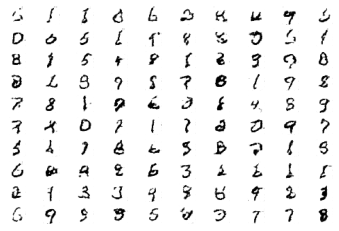

In [2]:
# example of loading the generator model and generating images
import tensorflow as tf
from tensorflow.keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create a plot of generated images (reversed grayscale)
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('model_018740.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
plot_generated(X, 10)